#Load libraries

In [1]:
!pip install cartopy --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 67.2 MB/s eta 0:00:00


#Load Data

vegUrban_2020_constBuiltUp2020_100m.csv
vegUrban_1990_constBuiltUp1992_100m.csv
treeUrban_2020_constBuiltUp2020_100m.csv
treeUrban_1990_constBuiltUp1992_100m.csv
croplandUrban_1990_constBuiltUp1990_100m.csv
croplandUrban_2020_constBuiltUp2020_100m.csv
grassUrban_1990_constBuiltUp1990_100m.csv
grassUrban_2020_constBuiltUp2020_100m.csv
shrubUrban_1990_constBuiltUp1990_100m.csv
shrubUrban_2020_constBuiltUp2020_100m.csv



#Maps

/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


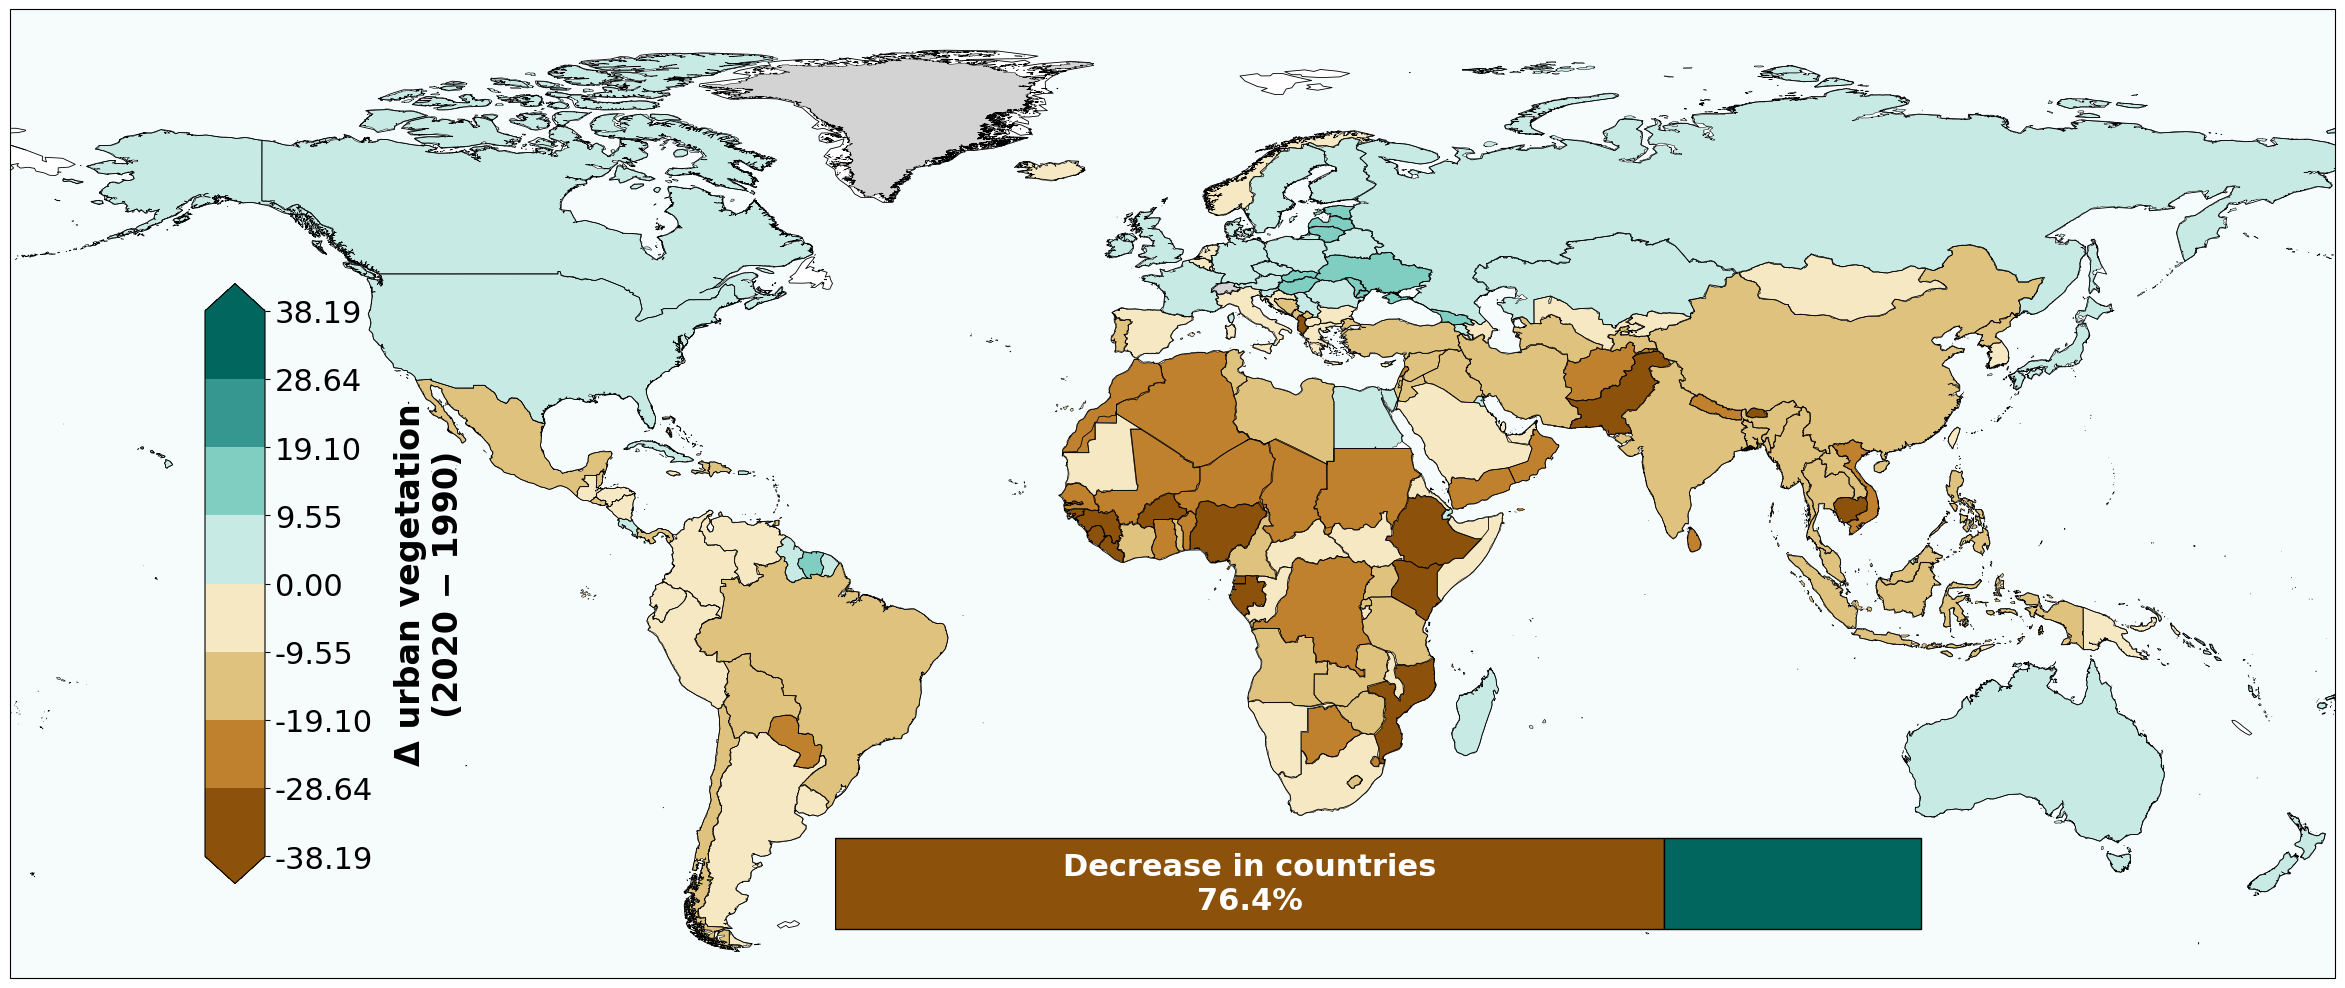

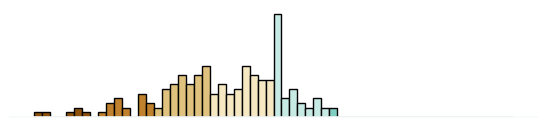

In [7]:
import os
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import shape as shp_shape
from matplotlib.colors import BoundaryNorm, ListedColormap
from matplotlib.cm import ScalarMappable

# -----------------------------
# CONFIG — edit these if needed
# -----------------------------
CSV_1990 = "/content/vegUrban_1990_constBuiltUp1992_100m.csv"
CSV_2020 = "/content/vegUrban_2020_constBuiltUp2020_100m.csv"

METRIC_COL = 'veg_pct_in_urban'  # or 'veg_frac_in_urban', 'veg_in_urban_m2'

MAP_FIG_PATH  = "/content/FigE5_map.pdf"
HIST_FIG_PATH = "/content/FigE5_hist.pdf"

# Diverging palette (brown → white → green; white is the zero *boundary* only)
DIVERGING_COLS = [
    '#8c510a', '#bf812d', '#dfc27d', '#f6e8c3',
    '#ffffff',
    '#c7eae5', '#80cdc1', '#35978f', '#01665e'
]
BROWN_LEFT = '#8c510a'  # negative side color (decrease)
TEAL_RIGHT = '#01665e'  # positive side color (increase)

# Compact % bar placement and style
PCT_BAR_BOX = [0.40, 0.275, 0.38, 0.05]  # [left, bottom, width, height] in figure coords
PCT_BAR_FONTSIZE = 22
INCLUDE_ZERO_IN_PCT = False  # False = exclude exact zeros from denominator

# -----------------------------
# Palette helpers (zero split)
# -----------------------------
def _split_center_palette(cols):
    if len(cols) % 2 != 1:
        raise ValueError("DIVERGING_COLS must have odd length with a single center color for 0.")
    mid = len(cols) // 2
    neg_cols = cols[:mid]      # below 0
    pos_cols = cols[mid+1:]    # above 0
    if len(neg_cols) != len(pos_cols):
        raise ValueError("Negative and positive sides must be symmetric in length.")
    return neg_cols, pos_cols

def _build_zero_split_bounds(abs_max, n_neg, n_pos):
    A = float(abs(abs_max))
    if not np.isfinite(A) or A <= 0:
        A = 1e-6
    left  = np.linspace(-A, 0.0, n_neg + 1, endpoint=True)
    right = np.linspace(0.0,  A, n_pos + 1, endpoint=True)[1:]  # drop duplicate 0
    return np.concatenate([left, right])

# -----------------------------
# I/O + validation helpers
# -----------------------------
def _load_pair():
    """Prefer in-memory; else read from CSV_1990/CSV_2020."""
    try:
        global vegUrban1990, vegUrban2020
        if isinstance(vegUrban1990, pd.DataFrame) and isinstance(vegUrban2020, pd.DataFrame):
            return vegUrban1990.copy(), vegUrban2020.copy()
    except NameError:
        pass

    if CSV_1990 is None or CSV_2020 is None:
        raise RuntimeError(
            "Provide in-memory DataFrames `vegUrban1990` & `vegUrban2020`, "
            "or set CSV_1990 and CSV_2020 to file paths."
        )
    if not os.path.exists(CSV_1990):
        raise FileNotFoundError(f"CSV_1990 not found: {CSV_1990}")
    if not os.path.exists(CSV_2020):
        raise FileNotFoundError(f"CSV_2020 not found: {CSV_2020}")

    try:
        df1990 = pd.read_csv(CSV_1990)
        df2020 = pd.read_csv(CSV_2020)
    except Exception as e:
        raise RuntimeError(f"Error reading CSVs: {e}") from e

    return df1990, df2020

def _ensure_cols(df, year_label):
    req = ['shapeName', METRIC_COL]
    miss = [c for c in req if c not in df.columns]
    if miss:
        raise KeyError(f"Missing required columns in {year_label}: {miss}")

def _add_geometry(df, year_label):
    """Create geometry from '.geo' if needed; return GeoDataFrame (EPSG:4326)."""
    if 'geometry' in df.columns and gpd.array.is_geometry_type(df['geometry']):
        return gpd.GeoDataFrame(df, geometry='geometry', crs='EPSG:4326')

    if '.geo' not in df.columns:
        raise KeyError(f"Neither 'geometry' nor '.geo' found in {year_label}; cannot build geometries.")

    def parse(x):
        if pd.isna(x):
            return None
        try:
            return shp_shape(json.loads(x))
        except Exception as e:
            raise RuntimeError(f"Failed parsing .geo in {year_label}: {e}") from e

    geom = df['.geo'].apply(parse)
    return gpd.GeoDataFrame(df.copy(), geometry=geom, crs='EPSG:4326')

# -----------------------------
# Compact % bar
# -----------------------------
def _draw_percent_bar(fig,
                      neg_pct, pos_pct,
                      neg_label="Decrease in countries", pos_label="Increase in countries",
                      box=PCT_BAR_BOX, fontsize=PCT_BAR_FONTSIZE,
                      left_color=BROWN_LEFT, right_color=TEAL_RIGHT,
                      swap_order=False):
    """
    Draw a small stacked horizontal bar on the figure (percent scale).
    - neg_pct/pos_pct: percentages (0–100).
    - Text is placed on the NEGATIVE bar: "Decrease in countries\nXX.X%".
    """
    try:
        neg = max(0.0, float(neg_pct))
        pos = max(0.0, float(pos_pct))
    except Exception as e:
        print(f"Warning: invalid percentages for percent bar: {e}")
        return

    total = neg + pos
    if total <= 0:
        return

    try:
        axb = fig.add_axes(list(box))
        axb.set_axis_off()

        if swap_order:
            # Positive on the left, negative on the right
            axb.barh([""], [pos], color=right_color, edgecolor='black', height=0.6)
            axb.barh([""], [neg], color=left_color,  edgecolor='black', height=0.6, left=pos)

            # Label ONLY the negative segment
            if neg > 2:
                axb.text(
                    pos + neg / 2, 0,
                    f"{neg_label}\n{neg:.1f}%",
                    ha='center', va='center',
                    fontsize=fontsize, color='white', weight='bold'
                )

        else:
            # Negative on the left, positive on the right
            axb.barh([""], [neg], color=left_color,  edgecolor='black', height=0.6)
            axb.barh([""], [pos], color=right_color, edgecolor='black', height=0.6, left=neg)

            # Label ONLY the negative segment
            if neg > 2:
                axb.text(
                    neg / 2, 0,
                    f"{neg_label}\n{neg:.1f}%",
                    ha='center', va='center',
                    fontsize=fontsize, color='white', weight='bold'
                )

        for s in axb.spines.values():
            s.set_visible(False)
        axb.set_xticks([]); axb.set_yticks([])

    except Exception as e:
        print(f"Warning: percent bar failed to draw: {e}")

# -----------------------------
# Histogram (zero-break)
# -----------------------------
def create_frequency_plot_diverging(data, neg_cols, pos_cols, n_bins_half=120, save_path=None):
    """
    Frequency histogram with a hard class break at 0.
    Colors: negative bins use neg_cols; positive bins use pos_cols; 0 is a boundary.
    """
    try:
        arr = np.asarray(pd.to_numeric(data, errors='coerce'), dtype=float)
        arr = arr[~np.isnan(arr)]
        if arr.size == 0:
            raise ValueError("No valid data available for histogram plotting.")

        # Central 95% for stability
        p2_5, p97_5 = np.percentile(arr, [2.5, 97.5])
        arr = arr[(arr >= p2_5) & (arr <= p97_5)]
        if arr.size == 0:
            raise ValueError("No data within 2.5–97.5 percentile range.")

        # Symmetric span
        abs_max = max(abs(arr.min()), abs(arr.max()))
        if abs_max == 0:
            abs_max = 1e-6

        # Dense histogram bins (for smoothness)
        bins_left  = np.linspace(-abs_max, 0.0, int(n_bins_half) + 1)
        bins_right = np.linspace(0.0,  abs_max, int(n_bins_half) + 1)[1:]
        bins = np.concatenate([bins_left, bins_right])

        # Coarse class bounds with exact zero split
        bounds = _build_zero_split_bounds(abs_max, len(neg_cols), len(pos_cols))
        colors = neg_cols + pos_cols
        cmap = ListedColormap(colors)
        norm = BoundaryNorm(bounds, ncolors=len(colors), clip=True)

        # Plot
        fig, ax = plt.subplots(figsize=(6.8, 1.4))
        counts, edges, patches = ax.hist(arr, bins=bins, edgecolor='black', linewidth=1)

        # Color by class (midpoints)
        for patch, l, r in zip(patches, edges[:-1], edges[1:]):
            mid = 0.5 * (l + r)
            patch.set_facecolor(cmap(norm(mid)))

        # Minimal styling
        ax.set_xticks([]); ax.set_yticks([])
        for s in ax.spines.values():
            s.set_visible(False)
        ax.spines['bottom'].set_visible(True)
        ax.spines['bottom'].set_color('#f6fbfc')
        ax.spines['bottom'].set_linewidth(1.2)
        fig.patch.set_alpha(0)
        ax.patch.set_alpha(0)

        if save_path:
            os.makedirs(os.path.dirname(save_path), exist_ok=True)
            plt.savefig(save_path, dpi=400, bbox_inches='tight')
        plt.show()

    except Exception as e:
        raise RuntimeError(f"Error in creating diverging frequency plot: {e}")

# -----------------------------
# MAIN
# -----------------------------
def main():
    # 1) Load data
    df1990, df2020 = _load_pair()

    # 2) Validate columns
    _ensure_cols(df1990, "1990")
    _ensure_cols(df2020, "2020")

    # 3) Geometry
    gdf1990 = _add_geometry(df1990, "1990")
    gdf2020 = _add_geometry(df2020, "2020")

    # 4) Aggregate mean metric per shapeName
    try:
        g1990 = gdf1990.groupby("shapeName", as_index=False)[METRIC_COL].mean()
        g2020 = gdf2020.groupby("shapeName", as_index=False)[METRIC_COL].mean()
    except Exception as e:
        raise RuntimeError(f"Grouping/aggregation failed: {e}") from e

    # 5) Compute delta and attach geometry (use 2020 geometries as representative)
    merged = pd.merge(g1990, g2020, on="shapeName", suffixes=("_1990", "_2020"))
    merged["delta"] = merged[f"{METRIC_COL}_2020"] - merged[f"{METRIC_COL}_1990"]
    geo = gdf2020.drop_duplicates("shapeName")[["shapeName", "geometry"]]
    final = geo.merge(merged[["shapeName", "delta"]], on="shapeName", how="left")
    final = gpd.GeoDataFrame(final, geometry="geometry", crs="EPSG:4326")

    # 6) Build zero-split color logic
    try:
        neg_cols, pos_cols = _split_center_palette(DIVERGING_COLS)
    except Exception as e:
        raise RuntimeError(f"Palette error: {e}") from e

    # 7) MAP — exact zero break classes + % bar
    try:
        fig, ax = plt.subplots(figsize=(30, 20), subplot_kw={'projection': ccrs.PlateCarree()})
        ax.add_feature(cfeature.COASTLINE, linewidth=0.6)
        ax.add_feature(cfeature.BORDERS, linewidth=0.6)
        ax.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.1)
        ax.add_feature(cfeature.LAND, facecolor='white')
        ax.set_extent([-180, 180, -60, 90], crs=ccrs.PlateCarree())

        valid = final["delta"].dropna()
        if valid.empty:
            raise ValueError("No valid 'delta' values found for plotting.")

        # Robust symmetric span (95th percentile of |delta|)
        abs_max = np.percentile(np.abs(valid.to_numpy()), 95)
        if abs_max <= 0 or not np.isfinite(abs_max):
            abs_max = max(abs(valid.min()), abs(valid.max()), 1e-6)

        # Zero-split bounds and discrete cmap (no center color)
        bounds = _build_zero_split_bounds(abs_max, len(neg_cols), len(pos_cols))
        colors = neg_cols + pos_cols
        cmap_discrete = ListedColormap(colors)
        norm = BoundaryNorm(boundaries=bounds, ncolors=len(colors), clip=True)

        # Draw polygons
        final.plot(
            column="delta",
            ax=ax,
            cmap=cmap_discrete,
            norm=norm,
            edgecolor="black",
            linewidth=0.35,
            missing_kwds={'color': 'lightgrey', 'label': 'No data'}
        )

        # Colorbar with explicit 0 break
        cbar_ax = fig.add_axes([0.19, 0.3, 0.02, 0.3])
        sm = ScalarMappable(norm=norm, cmap=cmap_discrete)
        sm._A = []
        cbar = plt.colorbar(sm, cax=cbar_ax, orientation='vertical', extend='both')
        cbar.set_label("Δ urban vegetation\n(2020 − 1990)", fontsize=24, labelpad=15, fontweight='bold')
        cbar.set_ticks(bounds)
        cbar.set_ticklabels([f"{b:.2f}" for b in bounds])
        cbar.ax.tick_params(labelsize=22)

        # ===== Compact % bar (zeros excluded by default) =====
        if INCLUDE_ZERO_IN_PCT:
            base = float(valid.size)
            neg_pct = float((valid < 0).sum()) / base * 100.0
            pos_pct = float((valid > 0).sum()) / base * 100.0
        else:
            nz = valid[valid != 0]
            base = float(nz.size)
            neg_pct = float((nz < 0).sum()) / base * 100.0 if base > 0 else 0.0
            pos_pct = float((nz > 0).sum()) / base * 100.0 if base > 0 else 0.0

        _draw_percent_bar(
            fig,
            neg_pct=neg_pct,
            pos_pct=pos_pct,
            neg_label="Decrease in countries",
            pos_label="Increase in countries",
            box=PCT_BAR_BOX,
            fontsize=PCT_BAR_FONTSIZE,
            left_color=BROWN_LEFT,
            right_color=TEAL_RIGHT,
            swap_order=False  # set True to place 'Increase' on the left, label stays on negative bar
        )

        os.makedirs(os.path.dirname(MAP_FIG_PATH), exist_ok=True)
        plt.savefig(MAP_FIG_PATH, bbox_inches='tight', dpi=400)
        plt.show()

    except Exception as e:
        raise RuntimeError(f"Error during diverging map plot: {e}") from e

    # 8) HISTOGRAM — same zero-break logic
    try:
        create_frequency_plot_diverging(
            data=valid,
            neg_cols=neg_cols,
            pos_cols=pos_cols,
            n_bins_half=30,
            save_path=HIST_FIG_PATH
        )
    except Exception as e:
        raise RuntimeError(f"Error during diverging histogram plot: {e}") from e

if __name__ == "__main__":
    try:
        main()
    except Exception as e:
        import sys, traceback
        print(f"\nERROR: {e}", file=sys.stderr)
        traceback.print_exc(limit=2)


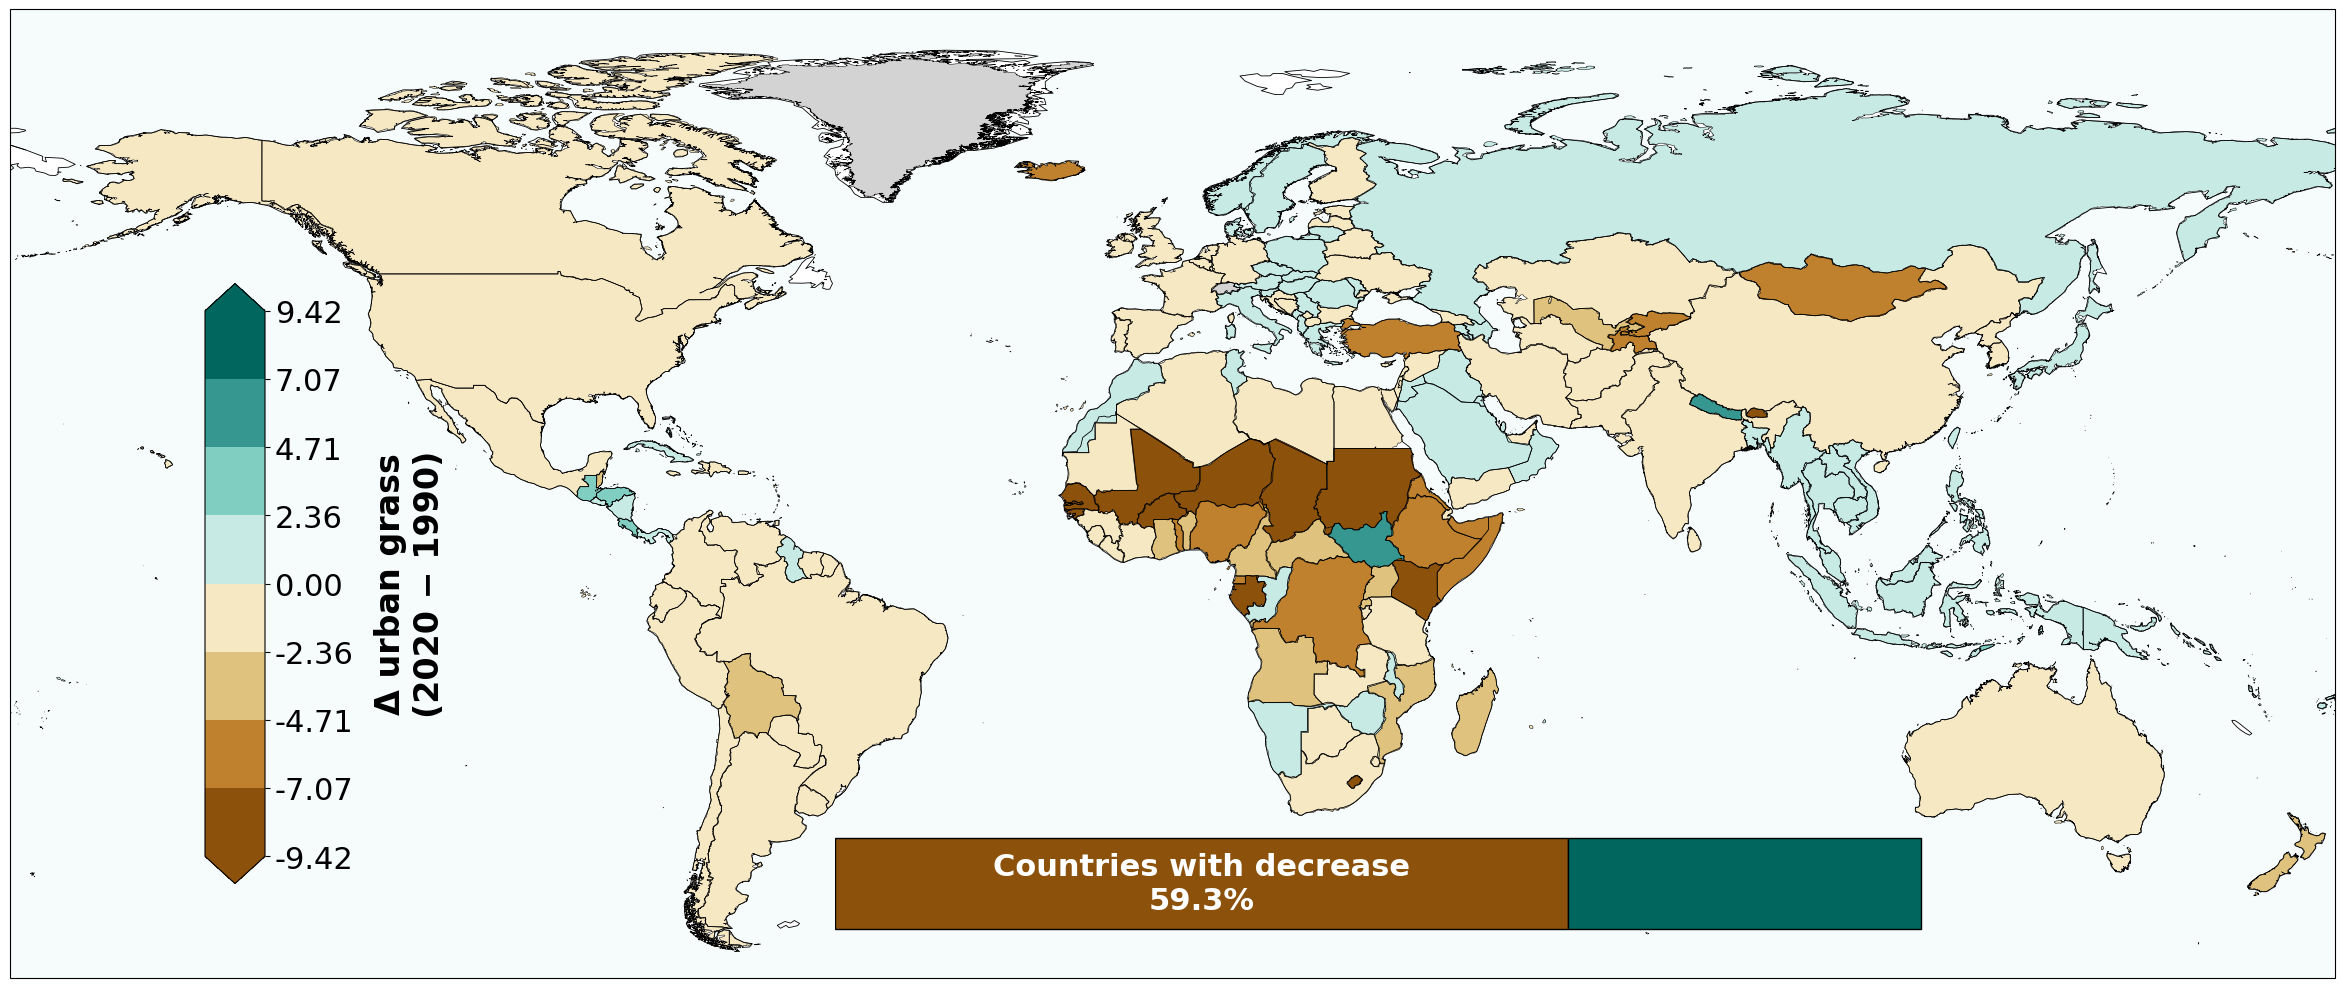

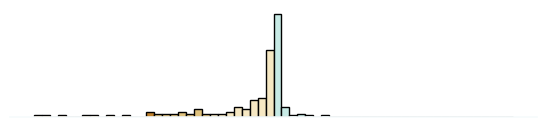

In [10]:
import os
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import shape as shp_shape
from matplotlib.colors import BoundaryNorm, ListedColormap
from matplotlib.cm import ScalarMappable

CSV_1990 = "/content/grassUrban_1990_constBuiltUp1990_100m.csv"
CSV_2020 = "/content/grassUrban_2020_constBuiltUp2020_100m.csv"

# Choose the metric column
METRIC_COL = 'grass_pct_in_urban'  # or 'grass_frac_in_urban', 'grass_in_urban_m2'

# Output figures
MAP_FIG_PATH  = "/content/EDFig10B_map.pdf"
HIST_FIG_PATH = "/content/EDFig10B_hist.pdf"

# --- Diverging palette (brown → white → green). White is the CENTER *boundary* (not used as a bin color) ---
DIVERGING_COLS = [
    '#8c510a', '#bf812d', '#dfc27d', '#f6e8c3',
    '#ffffff',  # center (0) -> used as a boundary only
    '#c7eae5', '#80cdc1', '#35978f', '#01665e'
]
BROWN_LEFT = '#8c510a'  # negative side color (decrease)
TEAL_RIGHT = '#01665e'  # positive side color (increase)

# Compact % bar placement (figure coords): [left, bottom, width, height]
PCT_BAR_BOX = [0.40, 0.275, 0.38, 0.05]
PCT_BAR_FONTSIZE = 22
# If you’d like Urban−Rural semantics instead of temporal change, flip labels below in the call site.

# -----------------------------
# Palette helpers (zero split)
# -----------------------------
def _split_center_palette(cols):
    """Split a diverging palette with an odd number of colors, where the center is the 0 breakpoint.
    Returns (neg_cols, pos_cols) with the center color removed.
    """
    if len(cols) % 2 != 1:
        raise ValueError("DIVERGING_COLS must have odd length with a single center color for 0.")
    mid = len(cols) // 2
    neg_cols = cols[:mid]      # below 0
    pos_cols = cols[mid+1:]    # above 0
    if len(neg_cols) != len(pos_cols):
        raise ValueError("Negative and positive sides must be symmetric in length.")
    return neg_cols, pos_cols

def _build_zero_split_bounds(abs_max, n_neg, n_pos):
    """Return boundaries with an exact 0 class break: [-A ... 0 | 0 ... +A].
    Number of intervals on each side equals n_neg and n_pos, respectively.
    """
    A = float(abs(abs_max))
    if not np.isfinite(A) or A <= 0:
        A = 1e-6
    left  = np.linspace(-A, 0.0, n_neg + 1, endpoint=True)
    right = np.linspace(0.0,  A, n_pos + 1, endpoint=True)[1:]  # drop duplicate 0
    return np.concatenate([left, right])

# -----------------------------
# I/O + validation helpers
# -----------------------------
def _load_pair():
    """
    Load two DataFrames:
    - Prefer in-memory `grassUrban1990` and `grassUrban2020` if they exist.
    - Else read from CSV_1990 / CSV_2020.
    """
    try:
        global grassUrban1990, grassUrban2020
        if isinstance(grassUrban1990, pd.DataFrame) and isinstance(grassUrban2020, pd.DataFrame):
            return grassUrban1990.copy(), grassUrban2020.copy()
    except NameError:
        pass

    if CSV_1990 is None or CSV_2020 is None:
        raise RuntimeError(
            "Provide in-memory DataFrames `grassUrban1990` and `grassUrban2020`, "
            "or set CSV_1990 and CSV_2020 to file paths."
        )
    if not os.path.exists(CSV_1990):
        raise FileNotFoundError(f"CSV_1990 not found: {CSV_1990}")
    if not os.path.exists(CSV_2020):
        raise FileNotFoundError(f"CSV_2020 not found: {CSV_2020}")

    try:
        df1990 = pd.read_csv(CSV_1990)
        df2020 = pd.read_csv(CSV_2020)
    except Exception as e:
        raise RuntimeError(f"Error reading CSVs: {e}") from e

    return df1990, df2020

def _ensure_cols(df, year_label):
    req = ['shapeName', METRIC_COL]
    miss = [c for c in req if c not in df.columns]
    if miss:
        raise KeyError(f"Missing required columns in {year_label}: {miss}")

def _add_geometry(df, year_label):
    """Create geometry from '.geo' if needed; return GeoDataFrame (EPSG:4326)."""
    if 'geometry' in df.columns and gpd.array.is_geometry_type(df['geometry']):
        return gpd.GeoDataFrame(df, geometry='geometry', crs='EPSG:4326')

    if '.geo' not in df.columns:
        raise KeyError(f"Neither 'geometry' nor '.geo' found in {year_label}; cannot build geometries.")

    def parse(x):
        if pd.isna(x):
            return None
        try:
            return shp_shape(json.loads(x))
        except Exception as e:
            raise RuntimeError(f"Failed parsing .geo in {year_label}: {e}") from e

    geom = df['.geo'].apply(parse)
    return gpd.GeoDataFrame(df.copy(), geometry=geom, crs='EPSG:4326')

# -----------------------------
# Compact % bar
# -----------------------------
def _draw_percent_bar(fig,
                      neg_pct, pos_pct,
                      neg_label="Decrease", pos_label="Increase",
                      box=PCT_BAR_BOX, fontsize=PCT_BAR_FONTSIZE,
                      left_color=BROWN_LEFT, right_color=TEAL_RIGHT,
                      swap_order=False):
    """
    Draw a small stacked horizontal bar on the figure (percent scale).
    - neg_pct/pos_pct: percentages (0–100), zeros excluded upstream.
    - swap_order=True will place 'Increase' on the left and 'Decrease' on the right.
    """
    try:
        neg = max(0.0, float(neg_pct))
        pos = max(0.0, float(pos_pct))
    except Exception as e:
        print(f"Warning: invalid percentages for percent bar: {e}")
        return

    total = neg + pos
    if total <= 0:
        return

    try:
        axb = fig.add_axes(list(box))
        axb.set_axis_off()

        if swap_order:
            # Increase first, then Decrease
            axb.barh([""], [pos], color=right_color, edgecolor='black', height=0.6)
            axb.barh([""], [neg], color=left_color,  edgecolor='black', height=0.6, left=pos)
            if pos > 2:
                axb.text(pos/2, 0, f"{pos_label}\n{pos:.1f}%", ha='center', va='center',
                         fontsize=fontsize, color='white', weight='bold')
            if neg > 2:
                axb.text(pos + neg/2, 0, f"{neg_label}\n{neg:.1f}%", ha='center', va='center',
                         fontsize=fontsize, color='white', weight='bold')
        else:
            # Decrease first, then Increase
            axb.barh([""], [neg], color=left_color,  edgecolor='black', height=0.6)
            axb.barh([""], [pos], color=right_color, edgecolor='black', height=0.6, left=neg)
            if neg > 2:
                axb.text(neg/2, 0, f"Countries with decrease\n{neg:.1f}%", ha='center', va='center',
                         fontsize=fontsize, color='white', weight='bold')
            if pos > 2:
                axb.text(neg + pos/2, 0, f"", ha='center', va='center',
                         fontsize=fontsize, color='white', weight='bold')

        for s in axb.spines.values():
            s.set_visible(False)
        axb.set_xticks([]); axb.set_yticks([])

    except Exception as e:
        print(f"Warning: percent bar failed to draw: {e}")

# -----------------------------
# Histogram (zero-break)
# -----------------------------
def create_frequency_plot_diverging(data, neg_cols, pos_cols, n_bins_half=120, save_path=None):
    """
    Frequency histogram with a hard class break at 0.
    Colors: negative bins use neg_cols; positive bins use pos_cols; 0 is a boundary.
    """
    try:
        arr = np.asarray(pd.to_numeric(data, errors='coerce'), dtype=float)
        arr = arr[~np.isnan(arr)]
        if arr.size == 0:
            raise ValueError("No valid data available for histogram plotting.")

        # Central 95% for stability
        p2_5, p97_5 = np.percentile(arr, [2.5, 97.5])
        arr = arr[(arr >= p2_5) & (arr <= p97_5)]
        if arr.size == 0:
            raise ValueError("No data within 2.5–97.5 percentile range.")

        # Symmetric span
        abs_max = max(abs(arr.min()), abs(arr.max()))
        if abs_max == 0:
            abs_max = 1e-6

        # Dense histogram bins (for smoothness)
        bins_left  = np.linspace(-abs_max, 0.0, int(n_bins_half) + 1)
        bins_right = np.linspace(0.0,  abs_max, int(n_bins_half) + 1)[1:]
        bins = np.concatenate([bins_left, bins_right])

        # Coarse class bounds with exact zero split
        bounds = _build_zero_split_bounds(abs_max, len(neg_cols), len(pos_cols))
        colors = neg_cols + pos_cols
        cmap = ListedColormap(colors)
        norm = BoundaryNorm(bounds, ncolors=len(colors), clip=True)

        # Plot
        fig, ax = plt.subplots(figsize=(6.8, 1.4))
        counts, edges, patches = ax.hist(arr, bins=bins, edgecolor='black', linewidth=1)

        # Color by class (midpoints)
        for patch, l, r in zip(patches, edges[:-1], edges[1:]):
            mid = 0.5 * (l + r)
            patch.set_facecolor(cmap(norm(mid)))

        # Zero reference
        # ax.axvline(0, color='black', linestyle='--', linewidth=1.2)

        # Minimal styling
        ax.set_xticks([]); ax.set_yticks([])
        for s in ax.spines.values(): s.set_visible(False)
        ax.spines['bottom'].set_visible(True)
        ax.spines['bottom'].set_color('#f6fbfc'); ax.spines['bottom'].set_linewidth(1.2)
        fig.patch.set_alpha(0); ax.patch.set_alpha(0)

        if save_path:
            os.makedirs(os.path.dirname(save_path), exist_ok=True)
            plt.savefig(save_path, dpi=400, bbox_inches='tight')
        plt.show()

    except Exception as e:
        raise RuntimeError(f"Error in creating diverging frequency plot: {e}")

# -----------------------------
# MAIN
# -----------------------------
def main():
    # 1) Load data
    df1990, df2020 = _load_pair()

    # 2) Validate columns
    _ensure_cols(df1990, "1990")
    _ensure_cols(df2020, "2020")

    # 3) Geometry
    gdf1990 = _add_geometry(df1990, "1990")
    gdf2020 = _add_geometry(df2020, "2020")

    # 4) Aggregate mean metric per shapeName
    try:
        g1990 = gdf1990.groupby("shapeName", as_index=False)[METRIC_COL].mean()
        g2020 = gdf2020.groupby("shapeName", as_index=False)[METRIC_COL].mean()
    except Exception as e:
        raise RuntimeError(f"Grouping/aggregation failed: {e}") from e

    # 5) Compute delta and attach geometry (use 2020 geometries as representative)
    merged = pd.merge(g1990, g2020, on="shapeName", suffixes=("_1990", "_2020"))
    merged["delta"] = merged[f"{METRIC_COL}_2020"] - merged[f"{METRIC_COL}_1990"]
    geo = gdf2020.drop_duplicates("shapeName")[["shapeName", "geometry"]]
    final = geo.merge(merged[["shapeName", "delta"]], on="shapeName", how="left")
    final = gpd.GeoDataFrame(final, geometry="geometry", crs="EPSG:4326")

    # 6) Build zero-split color logic
    try:
        neg_cols, pos_cols = _split_center_palette(DIVERGING_COLS)
    except Exception as e:
        raise RuntimeError(f"Palette error: {e}") from e

    # 7) MAP — exact zero break classes + % bar
    try:
        fig, ax = plt.subplots(figsize=(30, 20), subplot_kw={'projection': ccrs.PlateCarree()})
        ax.add_feature(cfeature.COASTLINE, linewidth=0.6)
        ax.add_feature(cfeature.BORDERS, linewidth=0.6)
        ax.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.1)
        ax.add_feature(cfeature.LAND, facecolor='white')
        ax.set_extent([-180, 180, -60, 90], crs=ccrs.PlateCarree())

        valid = final["delta"].dropna()
        if valid.empty:
            raise ValueError("No valid 'delta' values found for plotting.")

        # Robust symmetric span (95th percentile of |delta|)
        abs_max = np.percentile(np.abs(valid.to_numpy()), 95)
        if abs_max <= 0 or not np.isfinite(abs_max):
            abs_max = max(abs(valid.min()), abs(valid.max()), 1e-6)

        # Zero-split bounds and discrete cmap (no center color)
        bounds = _build_zero_split_bounds(abs_max, len(neg_cols), len(pos_cols))
        colors = neg_cols + pos_cols
        cmap_discrete = ListedColormap(colors)
        norm = BoundaryNorm(boundaries=bounds, ncolors=len(colors), clip=True)

        # Draw polygons
        final.plot(
            column="delta",
            ax=ax,
            cmap=cmap_discrete,
            norm=norm,
            edgecolor="black",
            linewidth=0.35,
            missing_kwds={'color': 'lightgrey', 'label': 'No data'}
        )

        # Colorbar with explicit 0 break
        cbar_ax = fig.add_axes([0.19, 0.3, 0.02, 0.3])
        sm = ScalarMappable(norm=norm, cmap=cmap_discrete); sm._A = []
        cbar = plt.colorbar(sm, cax=cbar_ax, orientation='vertical', extend='both')
        cbar.set_label(f"Δ urban grass\n(2020 − 1990)", fontsize=24, labelpad=15, fontweight='bold')
        cbar.set_ticks(bounds)
        cbar.set_ticklabels([f"{b:.2f}" for b in bounds])
        cbar.ax.tick_params(labelsize=22)

        # ===== NEW: Compact % bar (zeros excluded) =====
        neg_pct = float((valid < 0).sum()) / float(valid.size) * 100.0
        pos_pct = float((valid > 0).sum()) / float(valid.size) * 100.0

        # For temporal change semantics:
        _draw_percent_bar(
            fig,
            neg_pct=neg_pct, pos_pct=pos_pct,
            neg_label="Decrease", pos_label="",
            box=PCT_BAR_BOX, fontsize=PCT_BAR_FONTSIZE,
            left_color=BROWN_LEFT, right_color=TEAL_RIGHT,
            swap_order=False  # set True to place Increase on the left
        )
        # If instead this figure represents URBAN − RURAL differences, use:
        # _draw_percent_bar(fig, neg_pct, pos_pct, "Rural > Urban", "Urban > Rural", box=PCT_BAR_BOX)

        os.makedirs(os.path.dirname(MAP_FIG_PATH), exist_ok=True)
        plt.savefig(MAP_FIG_PATH, bbox_inches='tight', dpi=400)
        plt.show()

    except Exception as e:
        raise RuntimeError(f"Error during diverging map plot: {e}") from e

    # 8) HISTOGRAM — same zero-break logic
    try:
        create_frequency_plot_diverging(
            data=valid,
            neg_cols=neg_cols,
            pos_cols=pos_cols,
            n_bins_half=30,
            save_path=HIST_FIG_PATH
        )
    except Exception as e:
        raise RuntimeError(f"Error during diverging histogram plot: {e}") from e

if __name__ == "__main__":
    try:
        main()
    except Exception as e:
        import sys, traceback
        print(f"\nERROR: {e}", file=sys.stderr)
        traceback.print_exc(limit=2)


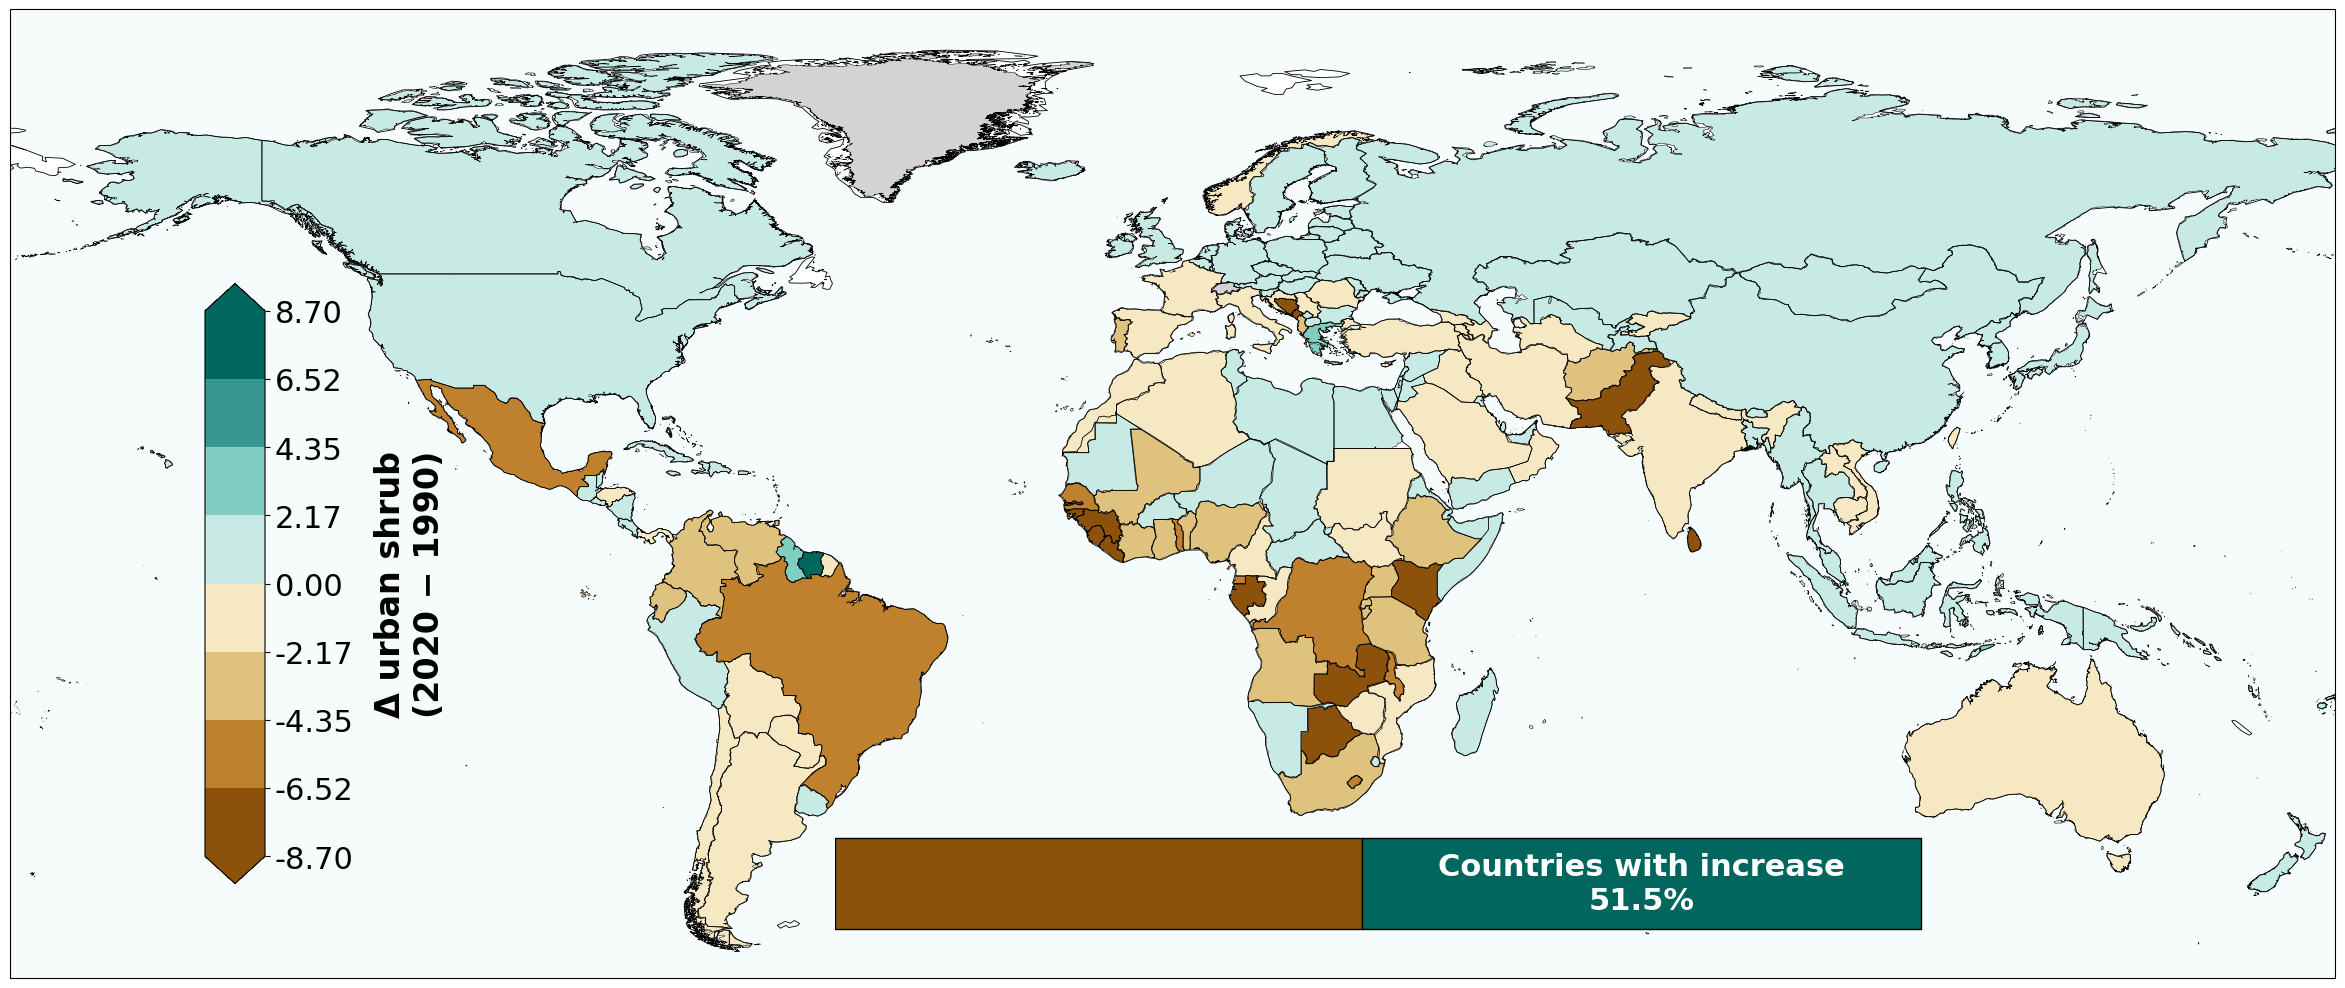

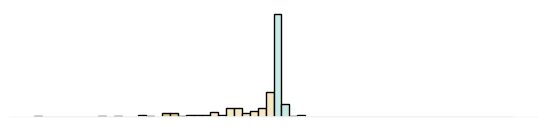

In [9]:
import os
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import shape as shp_shape
from matplotlib.colors import BoundaryNorm, ListedColormap
from matplotlib.cm import ScalarMappable

# -----------------------------
# CONFIG — edit these if needed
# -----------------------------
CSV_1990 = "/content/shrubUrban_1990_constBuiltUp1990_100m.csv"
CSV_2020 = "/content/shrubUrban_2020_constBuiltUp2020_100m.csv"

METRIC_COL = 'shrub_pct_in_urban'  # or 'shrub_frac_in_urban', 'shrub_in_urban_m2'

MAP_FIG_PATH  = "/content/EDFig10D_map.pdf"
HIST_FIG_PATH = "/content/EDFig10D_hist.pdf"

# Diverging palette (brown → white → green; white is the zero *boundary* only)
DIVERGING_COLS = [
    '#8c510a', '#bf812d', '#dfc27d', '#f6e8c3',
    '#ffffff',
    '#c7eae5', '#80cdc1', '#35978f', '#01665e'
]
BROWN_LEFT = '#8c510a'  # negative side color (decrease)
TEAL_RIGHT = '#01665e'  # positive side color (increase)

# Compact % bar placement and style
PCT_BAR_BOX = [0.40, 0.275, 0.38, 0.05]  # [left, bottom, width, height] in figure coords
PCT_BAR_FONTSIZE = 22
INCLUDE_ZERO_IN_PCT = False  # False = exclude exact zeros from denominator

# -----------------------------
# Palette helpers (zero split)
# -----------------------------
def _split_center_palette(cols):
    if len(cols) % 2 != 1:
        raise ValueError("DIVERGING_COLS must have odd length with a single center color for 0.")
    mid = len(cols) // 2
    neg_cols = cols[:mid]      # below 0
    pos_cols = cols[mid+1:]    # above 0
    if len(neg_cols) != len(pos_cols):
        raise ValueError("Negative and positive sides must be symmetric in length.")
    return neg_cols, pos_cols

def _build_zero_split_bounds(abs_max, n_neg, n_pos):
    A = float(abs(abs_max))
    if not np.isfinite(A) or A <= 0:
        A = 1e-6
    left  = np.linspace(-A, 0.0, n_neg + 1, endpoint=True)
    right = np.linspace(0.0,  A, n_pos + 1, endpoint=True)[1:]  # drop duplicate 0
    return np.concatenate([left, right])

# -----------------------------
# I/O + validation helpers
# -----------------------------
def _load_pair():
    """Prefer in-memory; else read from CSV_1990/CSV_2020."""
    try:
        global shrubUrban1990, shrubUrban2020
        if isinstance(shrubUrban1990, pd.DataFrame) and isinstance(shrubUrban2020, pd.DataFrame):
            return shrubUrban1990.copy(), shrubUrban2020.copy()
    except NameError:
        pass

    if CSV_1990 is None or CSV_2020 is None:
        raise RuntimeError(
            "Provide in-memory DataFrames `shrubUrban1990` & `shrubUrban2020`, "
            "or set CSV_1990 and CSV_2020 to file paths."
        )
    if not os.path.exists(CSV_1990):
        raise FileNotFoundError(f"CSV_1990 not found: {CSV_1990}")
    if not os.path.exists(CSV_2020):
        raise FileNotFoundError(f"CSV_2020 not found: {CSV_2020}")

    try:
        df1990 = pd.read_csv(CSV_1990)
        df2020 = pd.read_csv(CSV_2020)
    except Exception as e:
        raise RuntimeError(f"Error reading CSVs: {e}") from e

    return df1990, df2020

def _ensure_cols(df, year_label):
    req = ['shapeName', METRIC_COL]
    miss = [c for c in req if c not in df.columns]
    if miss:
        raise KeyError(f"Missing required columns in {year_label}: {miss}")

def _add_geometry(df, year_label):
    """Create geometry from '.geo' if needed; return GeoDataFrame (EPSG:4326)."""
    if 'geometry' in df.columns and gpd.array.is_geometry_type(df['geometry']):
        return gpd.GeoDataFrame(df, geometry='geometry', crs='EPSG:4326')

    if '.geo' not in df.columns:
        raise KeyError(f"Neither 'geometry' nor '.geo' found in {year_label}; cannot build geometries.")

    def parse(x):
        if pd.isna(x):
            return None
        try:
            return shp_shape(json.loads(x))
        except Exception as e:
            raise RuntimeError(f"Failed parsing .geo in {year_label}: {e}") from e

    geom = df['.geo'].apply(parse)
    return gpd.GeoDataFrame(df.copy(), geometry=geom, crs='EPSG:4326')

# -----------------------------
# Compact % bar
# -----------------------------
def _draw_percent_bar(fig,
                      neg_pct, pos_pct,
                      neg_label="Decrease", pos_label="Increase",
                      box=PCT_BAR_BOX, fontsize=PCT_BAR_FONTSIZE,
                      left_color=BROWN_LEFT, right_color=TEAL_RIGHT,
                      swap_order=False):
    """
    Draw a small stacked horizontal bar on the figure (percent scale).
    - neg_pct/pos_pct: percentages (0–100).
    - swap_order=True places positive on the left.
    """
    try:
        neg = max(0.0, float(neg_pct))
        pos = max(0.0, float(pos_pct))
    except Exception as e:
        print(f"Warning: invalid percentages for percent bar: {e}")
        return

    total = neg + pos
    if total <= 0:
        return

    try:
        axb = fig.add_axes(list(box))
        axb.set_axis_off()

        if swap_order:
            axb.barh([""], [pos], color=right_color, edgecolor='black', height=0.6)
            axb.barh([""], [neg], color=left_color,  edgecolor='black', height=0.6, left=pos)
            if pos > 2:
                axb.text(pos/2, 0, f"Countries with increase\n{pos:.1f}%", ha='center', va='center',
                         fontsize=fontsize, color='white', weight='bold')
            if neg > 2:
                axb.text(pos + neg/2, 0, f"", ha='center', va='center',
                         fontsize=fontsize, color='white', weight='bold')
        else:
            axb.barh([""], [neg], color=left_color,  edgecolor='black', height=0.6)
            axb.barh([""], [pos], color=right_color, edgecolor='black', height=0.6, left=neg)
            if neg > 2:
                axb.text(neg/2, 0, f"", ha='center', va='center',
                         fontsize=fontsize, color='white', weight='bold')
            if pos > 2:
                axb.text(neg + pos/2, 0, f"Countries with increase\n{pos:.1f}%", ha='center', va='center',
                         fontsize=fontsize, color='white', weight='bold')

        for s in axb.spines.values():
            s.set_visible(False)
        axb.set_xticks([]); axb.set_yticks([])

    except Exception as e:
        print(f"Warning: percent bar failed to draw: {e}")

# -----------------------------
# Histogram (zero-break)
# -----------------------------
def create_frequency_plot_diverging(data, neg_cols, pos_cols, n_bins_half=120, save_path=None):
    """
    Frequency histogram with a hard class break at 0.
    Colors: negative bins use neg_cols; positive bins use pos_cols; 0 is a boundary.
    """
    try:
        arr = np.asarray(pd.to_numeric(data, errors='coerce'), dtype=float)
        arr = arr[~np.isnan(arr)]
        if arr.size == 0:
            raise ValueError("No valid data available for histogram plotting.")

        # Central 95% for stability
        p2_5, p97_5 = np.percentile(arr, [2.5, 97.5])
        arr = arr[(arr >= p2_5) & (arr <= p97_5)]
        if arr.size == 0:
            raise ValueError("No data within 2.5–97.5 percentile range.")

        # Symmetric span
        abs_max = max(abs(arr.min()), abs(arr.max()))
        if abs_max == 0:
            abs_max = 1e-6

        # Dense histogram bins (for smoothness)
        bins_left  = np.linspace(-abs_max, 0.0, int(n_bins_half) + 1)
        bins_right = np.linspace(0.0,  abs_max, int(n_bins_half) + 1)[1:]
        bins = np.concatenate([bins_left, bins_right])

        # Coarse class bounds with exact zero split
        bounds = _build_zero_split_bounds(abs_max, len(neg_cols), len(pos_cols))
        colors = neg_cols + pos_cols
        cmap = ListedColormap(colors)
        norm = BoundaryNorm(bounds, ncolors=len(colors), clip=True)

        # Plot
        fig, ax = plt.subplots(figsize=(6.8, 1.4))
        counts, edges, patches = ax.hist(arr, bins=bins, edgecolor='black', linewidth=1)

        # Color by class (midpoints)
        for patch, l, r in zip(patches, edges[:-1], edges[1:]):
            mid = 0.5 * (l + r)
            patch.set_facecolor(cmap(norm(mid)))

        # Zero reference
        # ax.axvline(0, color='black', linestyle='--', linewidth=1.2)

        # Minimal styling
        ax.set_xticks([]); ax.set_yticks([])
        for s in ax.spines.values(): s.set_visible(False)
        ax.spines['bottom'].set_visible(True)
        ax.spines['bottom'].set_color('#f6fbfc'); ax.spines['bottom'].set_linewidth(1.2)
        fig.patch.set_alpha(0); ax.patch.set_alpha(0)

        if save_path:
            os.makedirs(os.path.dirname(save_path), exist_ok=True)
            plt.savefig(save_path, dpi=400, bbox_inches='tight')
        plt.show()

    except Exception as e:
        raise RuntimeError(f"Error in creating diverging frequency plot: {e}")

# -----------------------------
# MAIN
# -----------------------------
def main():
    # 1) Load data
    df1990, df2020 = _load_pair()

    # 2) Validate columns
    _ensure_cols(df1990, "1990")
    _ensure_cols(df2020, "2020")

    # 3) Geometry
    gdf1990 = _add_geometry(df1990, "1990")
    gdf2020 = _add_geometry(df2020, "2020")

    # 4) Aggregate mean metric per shapeName
    try:
        g1990 = gdf1990.groupby("shapeName", as_index=False)[METRIC_COL].mean()
        g2020 = gdf2020.groupby("shapeName", as_index=False)[METRIC_COL].mean()
    except Exception as e:
        raise RuntimeError(f"Grouping/aggregation failed: {e}") from e

    # 5) Compute delta and attach geometry (use 2020 geometries as representative)
    merged = pd.merge(g1990, g2020, on="shapeName", suffixes=("_1990", "_2020"))
    merged["delta"] = merged[f"{METRIC_COL}_2020"] - merged[f"{METRIC_COL}_1990"]
    geo = gdf2020.drop_duplicates("shapeName")[["shapeName", "geometry"]]
    final = geo.merge(merged[["shapeName", "delta"]], on="shapeName", how="left")
    final = gpd.GeoDataFrame(final, geometry="geometry", crs="EPSG:4326")

    # 6) Build zero-split color logic
    try:
        neg_cols, pos_cols = _split_center_palette(DIVERGING_COLS)
    except Exception as e:
        raise RuntimeError(f"Palette error: {e}") from e

    # 7) MAP — exact zero break classes + % bar
    try:
        fig, ax = plt.subplots(figsize=(30, 20), subplot_kw={'projection': ccrs.PlateCarree()})
        ax.add_feature(cfeature.COASTLINE, linewidth=0.6)
        ax.add_feature(cfeature.BORDERS, linewidth=0.6)
        ax.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.1)
        ax.add_feature(cfeature.LAND, facecolor='white')
        ax.set_extent([-180, 180, -60, 90], crs=ccrs.PlateCarree())

        valid = final["delta"].dropna()
        if valid.empty:
            raise ValueError("No valid 'delta' values found for plotting.")

        # Robust symmetric span (95th percentile of |delta|)
        abs_max = np.percentile(np.abs(valid.to_numpy()), 95)
        if abs_max <= 0 or not np.isfinite(abs_max):
            abs_max = max(abs(valid.min()), abs(valid.max()), 1e-6)

        # Zero-split bounds and discrete cmap (no center color)
        bounds = _build_zero_split_bounds(abs_max, len(neg_cols), len(pos_cols))
        colors = neg_cols + pos_cols
        cmap_discrete = ListedColormap(colors)
        norm = BoundaryNorm(boundaries=bounds, ncolors=len(colors), clip=True)

        # Draw polygons
        final.plot(
            column="delta",
            ax=ax,
            cmap=cmap_discrete,
            norm=norm,
            edgecolor="black",
            linewidth=0.35,
            missing_kwds={'color': 'lightgrey', 'label': 'No data'}
        )

        # Colorbar with explicit 0 break
        cbar_ax = fig.add_axes([0.19, 0.3, 0.02, 0.3])
        sm = ScalarMappable(norm=norm, cmap=cmap_discrete); sm._A = []
        cbar = plt.colorbar(sm, cax=cbar_ax, orientation='vertical', extend='both')
        cbar.set_label("Δ urban shrub\n(2020 − 1990)", fontsize=24, labelpad=15, fontweight='bold')
        cbar.set_ticks(bounds)
        cbar.set_ticklabels([f"{b:.2f}" for b in bounds])
        cbar.ax.tick_params(labelsize=22)

        # ===== Compact % bar (zeros excluded by default) =====
        if INCLUDE_ZERO_IN_PCT:
            base = float(valid.size)
            neg_pct = float((valid < 0).sum()) / base * 100.0
            pos_pct = float((valid > 0).sum()) / base * 100.0
        else:
            nz = valid[valid != 0]
            base = float(nz.size)
            neg_pct = float((nz < 0).sum()) / base * 100.0 if base > 0 else 0.0
            pos_pct = float((nz > 0).sum()) / base * 100.0 if base > 0 else 0.0

        _draw_percent_bar(
            fig,
            neg_pct=neg_pct, pos_pct=pos_pct,
            neg_label="Decrease", pos_label="Increase",
            box=PCT_BAR_BOX, fontsize=PCT_BAR_FONTSIZE,
            left_color=BROWN_LEFT, right_color=TEAL_RIGHT,
            swap_order=False  # set True to place 'Increase' on the left
        )
        # If this were URBAN − RURAL contrasts instead of temporal change:
        # _draw_percent_bar(fig, neg_pct, pos_pct, "Rural > Urban", "Urban > Rural", box=PCT_BAR_BOX)

        os.makedirs(os.path.dirname(MAP_FIG_PATH), exist_ok=True)
        plt.savefig(MAP_FIG_PATH, bbox_inches='tight', dpi=400)
        plt.show()

    except Exception as e:
        raise RuntimeError(f"Error during diverging map plot: {e}") from e

    # 8) HISTOGRAM — same zero-break logic
    try:
        create_frequency_plot_diverging(
            data=valid,
            neg_cols=neg_cols,
            pos_cols=pos_cols,
            n_bins_half=30,
            save_path=HIST_FIG_PATH
        )
    except Exception as e:
        raise RuntimeError(f"Error during diverging histogram plot: {e}") from e

if __name__ == "__main__":
    try:
        main()
    except Exception as e:
        import sys, traceback
        print(f"\nERROR: {e}", file=sys.stderr)
        traceback.print_exc(limit=2)


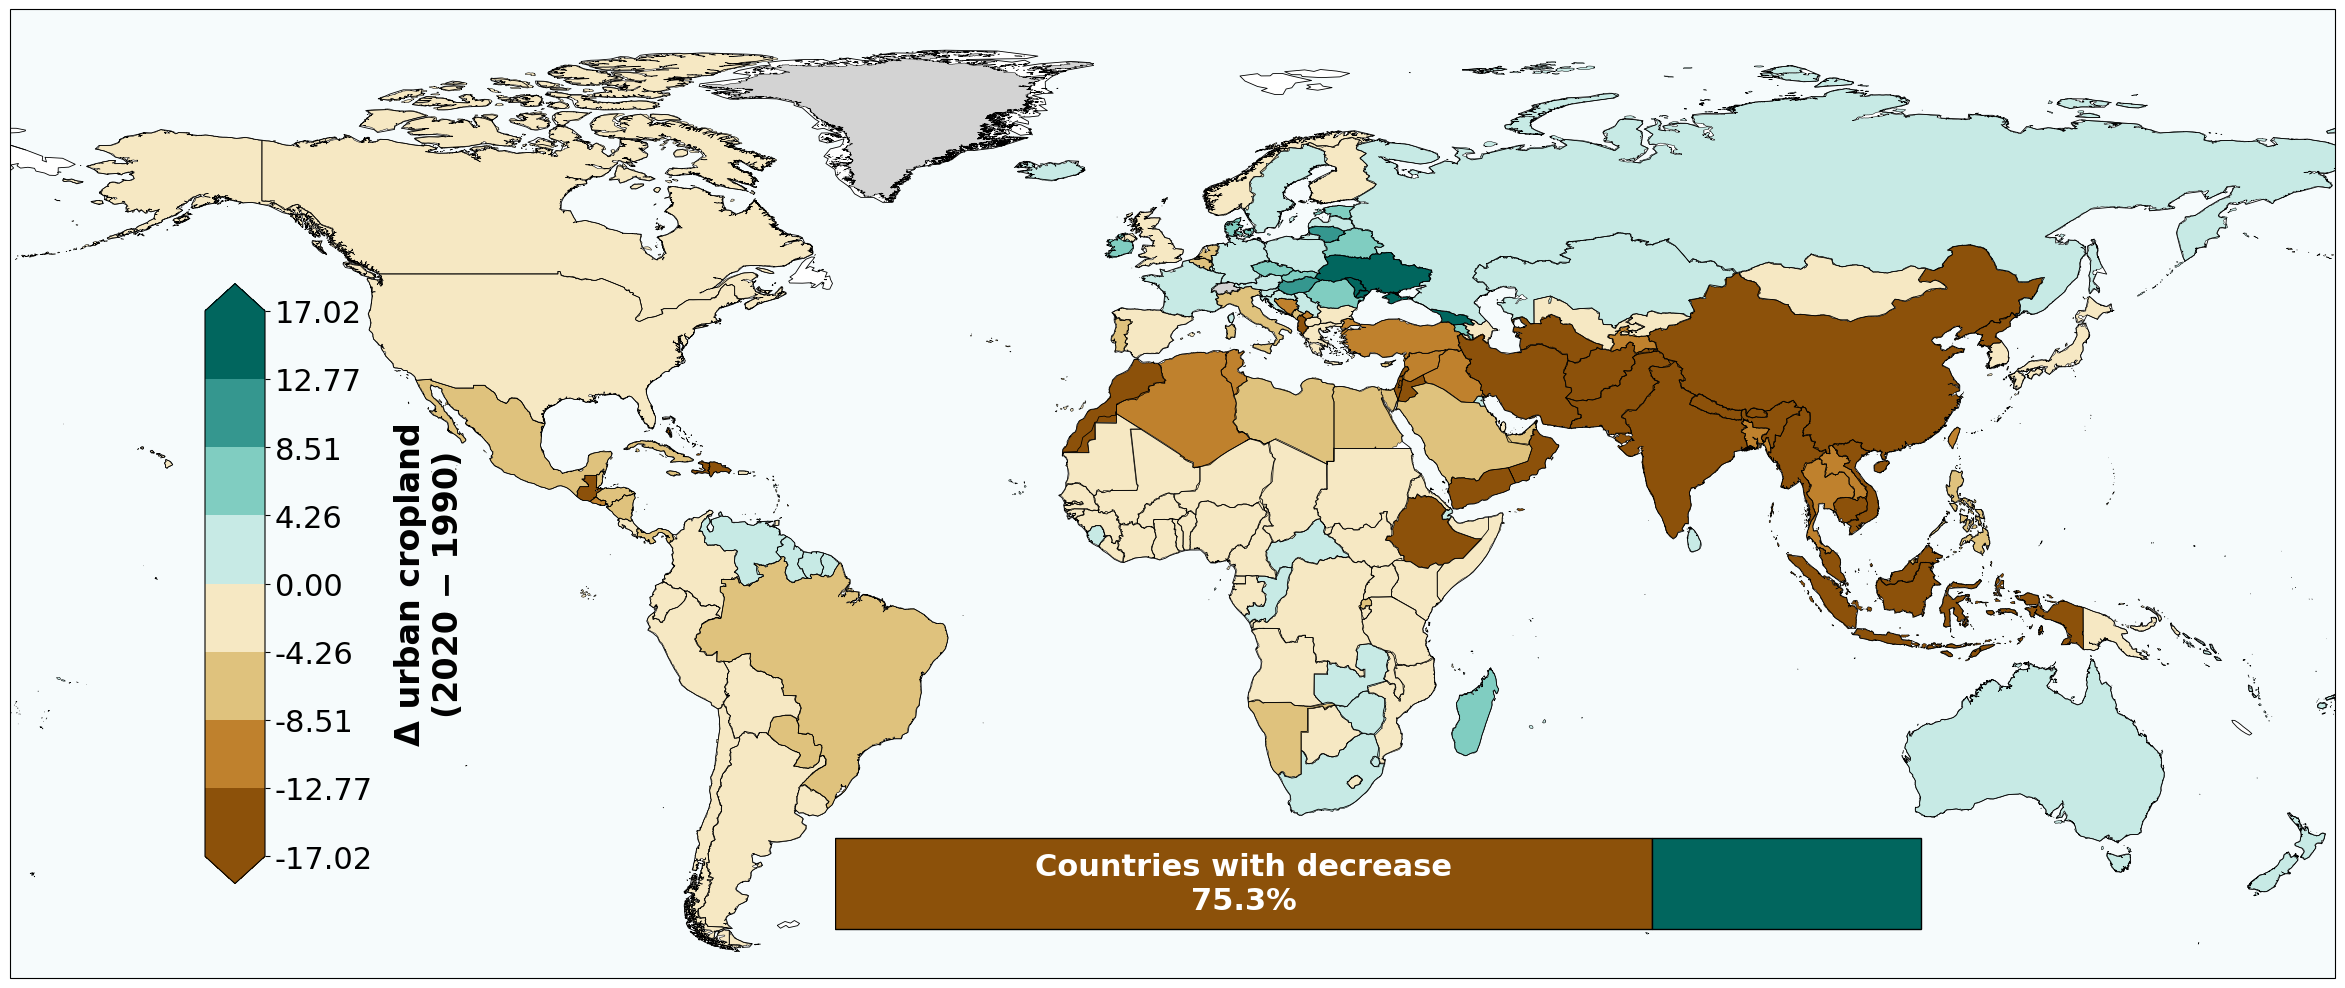

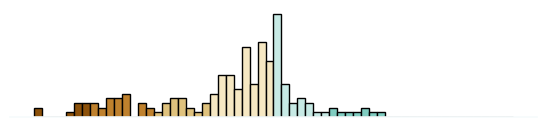

In [11]:
import os
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import shape as shp_shape
from matplotlib.colors import BoundaryNorm, ListedColormap
from matplotlib.cm import ScalarMappable

# -----------------------------
# CONFIG — edit these if needed
# -----------------------------
CSV_1990 = "/content/croplandUrban_1990_constBuiltUp1990_100m.csv"
CSV_2020 = "/content/croplandUrban_2020_constBuiltUp2020_100m.csv"

METRIC_COL = 'cropland_pct_in_urban'  # or 'cropland_frac_in_urban', 'cropland_in_urban_m2'

MAP_FIG_PATH  = "/content/EDFig10C_map.pdf"
HIST_FIG_PATH = "/content/EDFig10C_hist.pdf"

# Diverging palette (brown → white → green; white is the zero *boundary* only)
DIVERGING_COLS = [
    '#8c510a', '#bf812d', '#dfc27d', '#f6e8c3',
    '#ffffff',
    '#c7eae5', '#80cdc1', '#35978f', '#01665e'
]
BROWN_LEFT = '#8c510a'   # negative (decrease)
TEAL_RIGHT = '#01665e'   # positive (increase)

# Compact % bar placement & behavior
PCT_BAR_BOX = [0.40, 0.275, 0.38, 0.05]  # [left, bottom, width, height] in fig coords
PCT_BAR_FONTSIZE = 22
INCLUDE_ZERO_IN_PCT = False  # False: exclude exact zeros from denominator

# -----------------------------
# Palette / bounds helpers
# -----------------------------
def _split_center_palette(cols):
    if len(cols) % 2 != 1:
        raise ValueError("DIVERGING_COLS must have odd length with a single center color for 0.")
    mid = len(cols) // 2
    neg_cols = cols[:mid]
    pos_cols = cols[mid+1:]
    if len(neg_cols) != len(pos_cols):
        raise ValueError("Negative and positive sides must be symmetric in length.")
    return neg_cols, pos_cols

def _build_zero_split_bounds(abs_max, n_neg, n_pos):
    A = float(abs(abs_max))
    if not np.isfinite(A) or A <= 0:
        A = 1e-6
    left  = np.linspace(-A, 0.0, n_neg + 1, endpoint=True)
    right = np.linspace(0.0,  A, n_pos + 1, endpoint=True)[1:]  # drop duplicate 0
    return np.concatenate([left, right])

# -----------------------------
# I/O + validation helpers
# -----------------------------
def _load_pair():
    """Prefer in-memory; else read from CSV_1990/CSV_2020."""
    try:
        global croplandUrban1990, croplandUrban2020
        if isinstance(croplandUrban1990, pd.DataFrame) and isinstance(croplandUrban2020, pd.DataFrame):
            return croplandUrban1990.copy(), croplandUrban2020.copy()
    except NameError:
        pass

    if CSV_1990 is None or CSV_2020 is None:
        raise RuntimeError(
            "Provide in-memory DataFrames `croplandUrban1990` & `croplandUrban2020`, "
            "or set CSV_1990 and CSV_2020 to file paths."
        )
    if not os.path.exists(CSV_1990):
        raise FileNotFoundError(f"CSV_1990 not found: {CSV_1990}")
    if not os.path.exists(CSV_2020):
        raise FileNotFoundError(f"CSV_2020 not found: {CSV_2020}")

    try:
        df1990 = pd.read_csv(CSV_1990)
        df2020 = pd.read_csv(CSV_2020)
    except Exception as e:
        raise RuntimeError(f"Error reading CSVs: {e}") from e

    return df1990, df2020

def _ensure_cols(df, year_label):
    req = ['shapeName', METRIC_COL]
    miss = [c for c in req if c not in df.columns]
    if miss:
        raise KeyError(f"Missing required columns in {year_label}: {miss}")

def _add_geometry(df, year_label):
    """Create geometry from '.geo' if needed; return GeoDataFrame (EPSG:4326)."""
    if 'geometry' in df.columns and gpd.array.is_geometry_type(df['geometry']):
        return gpd.GeoDataFrame(df, geometry='geometry', crs='EPSG:4326')

    if '.geo' not in df.columns:
        raise KeyError(f"Neither 'geometry' nor '.geo' found in {year_label}; cannot build geometries.")

    def parse(x):
        if pd.isna(x):
            return None
        try:
            return shp_shape(json.loads(x))
        except Exception as e:
            raise RuntimeError(f"Failed parsing .geo in {year_label}: {e}") from e

    geom = df['.geo'].apply(parse)
    return gpd.GeoDataFrame(df.copy(), geometry=geom, crs='EPSG:4326')

# -----------------------------
# Compact % bar
# -----------------------------
def _draw_percent_bar(fig,
                      neg_pct, pos_pct,
                      neg_label="Decrease", pos_label="Increase",
                      box=PCT_BAR_BOX, fontsize=PCT_BAR_FONTSIZE,
                      left_color=BROWN_LEFT, right_color=TEAL_RIGHT,
                      swap_order=False):
    """
    Draw a small stacked horizontal bar on the figure (percent scale).
    - neg_pct/pos_pct: percentages (0–100).
    - swap_order=True places positive on the left.
    """
    try:
        neg = max(0.0, float(neg_pct))
        pos = max(0.0, float(pos_pct))
    except Exception as e:
        print(f"Warning: invalid percentages for percent bar: {e}")
        return

    total = neg + pos
    if total <= 0:
        return

    try:
        axb = fig.add_axes(list(box))
        axb.set_axis_off()

        if swap_order:
            axb.barh([""], [pos], color=right_color, edgecolor='black', height=0.6)
            axb.barh([""], [neg], color=left_color,  edgecolor='black', height=0.6, left=pos)
            if pos > 2:
                axb.text(pos/2, 0, f"{pos_label}\n{pos:.1f}%", ha='center', va='center',
                         fontsize=fontsize, color='white', weight='bold')
            if neg > 2:
                axb.text(pos + neg/2, 0, f"{neg_label}\n{neg:.1f}%", ha='center', va='center',
                         fontsize=fontsize, color='white', weight='bold')
        else:
            axb.barh([""], [neg], color=left_color,  edgecolor='black', height=0.6)
            axb.barh([""], [pos], color=right_color, edgecolor='black', height=0.6, left=neg)
            if neg > 2:
                axb.text(neg/2, 0, f"Countries with decrease\n{neg:.1f}%", ha='center', va='center',
                         fontsize=fontsize, color='white', weight='bold')
            if pos > 2:
                axb.text(neg + pos/2, 0, f"", ha='center', va='center',
                         fontsize=fontsize, color='white', weight='bold')

        for s in axb.spines.values():
            s.set_visible(False)
        axb.set_xticks([]); axb.set_yticks([])

    except Exception as e:
        print(f"Warning: percent bar failed to draw: {e}")

# -----------------------------
# Histogram (zero-break)
# -----------------------------
def create_frequency_plot_diverging(data, neg_cols, pos_cols, n_bins_half=120, save_path=None):
    """
    Frequency histogram with a hard class break at 0.
    Colors: negative bins use neg_cols; positive bins use pos_cols; 0 is a boundary.
    """
    try:
        arr = np.asarray(pd.to_numeric(data, errors='coerce'), dtype=float)
        arr = arr[~np.isnan(arr)]
        if arr.size == 0:
            raise ValueError("No valid data available for histogram plotting.")

        # Central 95% for stability
        p2_5, p97_5 = np.percentile(arr, [2.5, 97.5])
        arr = arr[(arr >= p2_5) & (arr <= p97_5)]
        if arr.size == 0:
            raise ValueError("No data within 2.5–97.5 percentile range.")

        # Symmetric span
        abs_max = max(abs(arr.min()), abs(arr.max()))
        if abs_max == 0:
            abs_max = 1e-6

        # Dense histogram bins (for smoothness)
        bins_left  = np.linspace(-abs_max, 0.0, int(n_bins_half) + 1)
        bins_right = np.linspace(0.0,  abs_max, int(n_bins_half) + 1)[1:]
        bins = np.concatenate([bins_left, bins_right])

        # Coarse class bounds with exact zero split
        bounds = _build_zero_split_bounds(abs_max, len(neg_cols), len(pos_cols))
        colors = neg_cols + pos_cols
        cmap = ListedColormap(colors)
        norm = BoundaryNorm(bounds, ncolors=len(colors), clip=True)

        # Plot
        fig, ax = plt.subplots(figsize=(6.8, 1.4))
        counts, edges, patches = ax.hist(arr, bins=bins, edgecolor='black', linewidth=1)

        # Color by class (midpoints)
        for patch, l, r in zip(patches, edges[:-1], edges[1:]):
            mid = 0.5 * (l + r)
            patch.set_facecolor(cmap(norm(mid)))

        # Zero reference
        # ax.axvline(0, color='black', linestyle='--', linewidth=1.2)

        # Minimal styling
        ax.set_xticks([]); ax.set_yticks([])
        for s in ax.spines.values(): s.set_visible(False)
        ax.spines['bottom'].set_visible(True)
        ax.spines['bottom'].set_color('#f6fbfc'); ax.spines['bottom'].set_linewidth(1.2)
        fig.patch.set_alpha(0); ax.patch.set_alpha(0)

        if save_path:
            os.makedirs(os.path.dirname(save_path), exist_ok=True)
            plt.savefig(save_path, dpi=400, bbox_inches='tight')
        plt.show()

    except Exception as e:
        raise RuntimeError(f"Error in creating diverging frequency plot: {e}")

# -----------------------------
# MAIN
# -----------------------------
def main():
    # 1) Load data
    df1990, df2020 = _load_pair()

    # 2) Validate columns
    _ensure_cols(df1990, "1990")
    _ensure_cols(df2020, "2020")

    # 3) Geometry
    gdf1990 = _add_geometry(df1990, "1990")
    gdf2020 = _add_geometry(df2020, "2020")

    # 4) Aggregate mean metric per shapeName
    try:
        g1990 = gdf1990.groupby("shapeName", as_index=False)[METRIC_COL].mean()
        g2020 = gdf2020.groupby("shapeName", as_index=False)[METRIC_COL].mean()
    except Exception as e:
        raise RuntimeError(f"Grouping/aggregation failed: {e}") from e

    # 5) Compute delta and attach geometry (use 2020 geometries as representative)
    merged = pd.merge(g1990, g2020, on="shapeName", suffixes=("_1990", "_2020"))
    merged["delta"] = merged[f"{METRIC_COL}_2020"] - merged[f"{METRIC_COL}_1990"]
    geo = gdf2020.drop_duplicates("shapeName")[["shapeName", "geometry"]]
    final = geo.merge(merged[["shapeName", "delta"]], on="shapeName", how="left")
    final = gpd.GeoDataFrame(final, geometry="geometry", crs="EPSG:4326")

    # 6) Colors/bounds
    try:
        neg_cols, pos_cols = _split_center_palette(DIVERGING_COLS)
    except Exception as e:
        raise RuntimeError(f"Palette error: {e}") from e

    # 7) MAP — exact zero break + % bar
    try:
        fig, ax = plt.subplots(figsize=(30, 20), subplot_kw={'projection': ccrs.PlateCarree()})
        ax.add_feature(cfeature.COASTLINE, linewidth=0.6)
        ax.add_feature(cfeature.BORDERS, linewidth=0.6)
        ax.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.1)
        ax.add_feature(cfeature.LAND, facecolor='white')
        ax.set_extent([-180, 180, -60, 90], crs=ccrs.PlateCarree())

        valid = final["delta"].dropna()
        if valid.empty:
            raise ValueError("No valid 'delta' values found for plotting.")

        # Robust symmetric span (95th percentile of |delta|)
        abs_max = np.percentile(np.abs(valid.to_numpy()), 95)
        if abs_max <= 0 or not np.isfinite(abs_max):
            abs_max = max(abs(valid.min()), abs(valid.max()), 1e-6)

        bounds = _build_zero_split_bounds(abs_max, len(neg_cols), len(pos_cols))
        colors = neg_cols + pos_cols
        cmap_discrete = ListedColormap(colors)
        norm = BoundaryNorm(boundaries=bounds, ncolors=len(colors), clip=True)

        # Draw polygons
        final.plot(
            column="delta",
            ax=ax,
            cmap=cmap_discrete,
            norm=norm,
            edgecolor="black",
            linewidth=0.35,
            missing_kwds={'color': 'lightgrey', 'label': 'No data'}
        )

        # Colorbar
        cbar_ax = fig.add_axes([0.19, 0.3, 0.02, 0.3])
        sm = ScalarMappable(norm=norm, cmap=cmap_discrete); sm._A = []
        cbar = plt.colorbar(sm, cax=cbar_ax, orientation='vertical', extend='both')
        cbar.set_label("Δ urban cropland\n(2020 − 1990)", fontsize=24, labelpad=15, fontweight='bold')
        cbar.set_ticks(bounds)
        cbar.set_ticklabels([f"{b:.2f}" for b in bounds])
        cbar.ax.tick_params(labelsize=22)

        # ===== Compact % bar =====
        if INCLUDE_ZERO_IN_PCT:
            base = float(valid.size)
            neg_pct = float((valid < 0).sum()) / base * 100.0
            pos_pct = float((valid > 0).sum()) / base * 100.0
        else:
            nz = valid[valid != 0]
            base = float(nz.size)
            neg_pct = float((nz < 0).sum()) / base * 100.0 if base > 0 else 0.0
            pos_pct = float((nz > 0).sum()) / base * 100.0 if base > 0 else 0.0

        _draw_percent_bar(
            fig,
            neg_pct=neg_pct, pos_pct=pos_pct,
            neg_label="Decrease", pos_label="Increase",
            box=PCT_BAR_BOX, fontsize=PCT_BAR_FONTSIZE,
            left_color=BROWN_LEFT, right_color=TEAL_RIGHT,
            swap_order=False  # True puts 'Increase' on the left
        )
        # For URBAN − RURAL contrasts (if you repurpose): use labels "Rural > Urban" / "Urban > Rural".

        os.makedirs(os.path.dirname(MAP_FIG_PATH), exist_ok=True)
        plt.savefig(MAP_FIG_PATH, bbox_inches='tight', dpi=400)
        plt.show()

    except Exception as e:
        raise RuntimeError(f"Error during diverging map plot: {e}") from e

    # 8) HISTOGRAM — same zero-break logic
    try:
        create_frequency_plot_diverging(
            data=valid,
            neg_cols=neg_cols,
            pos_cols=pos_cols,
            n_bins_half=30,
            save_path=HIST_FIG_PATH
        )
    except Exception as e:
        raise RuntimeError(f"Error during diverging histogram plot: {e}") from e

if __name__ == "__main__":
    try:
        main()
    except Exception as e:
        import sys, traceback
        print(f"\nERROR: {e}", file=sys.stderr)
        traceback.print_exc(limit=2)


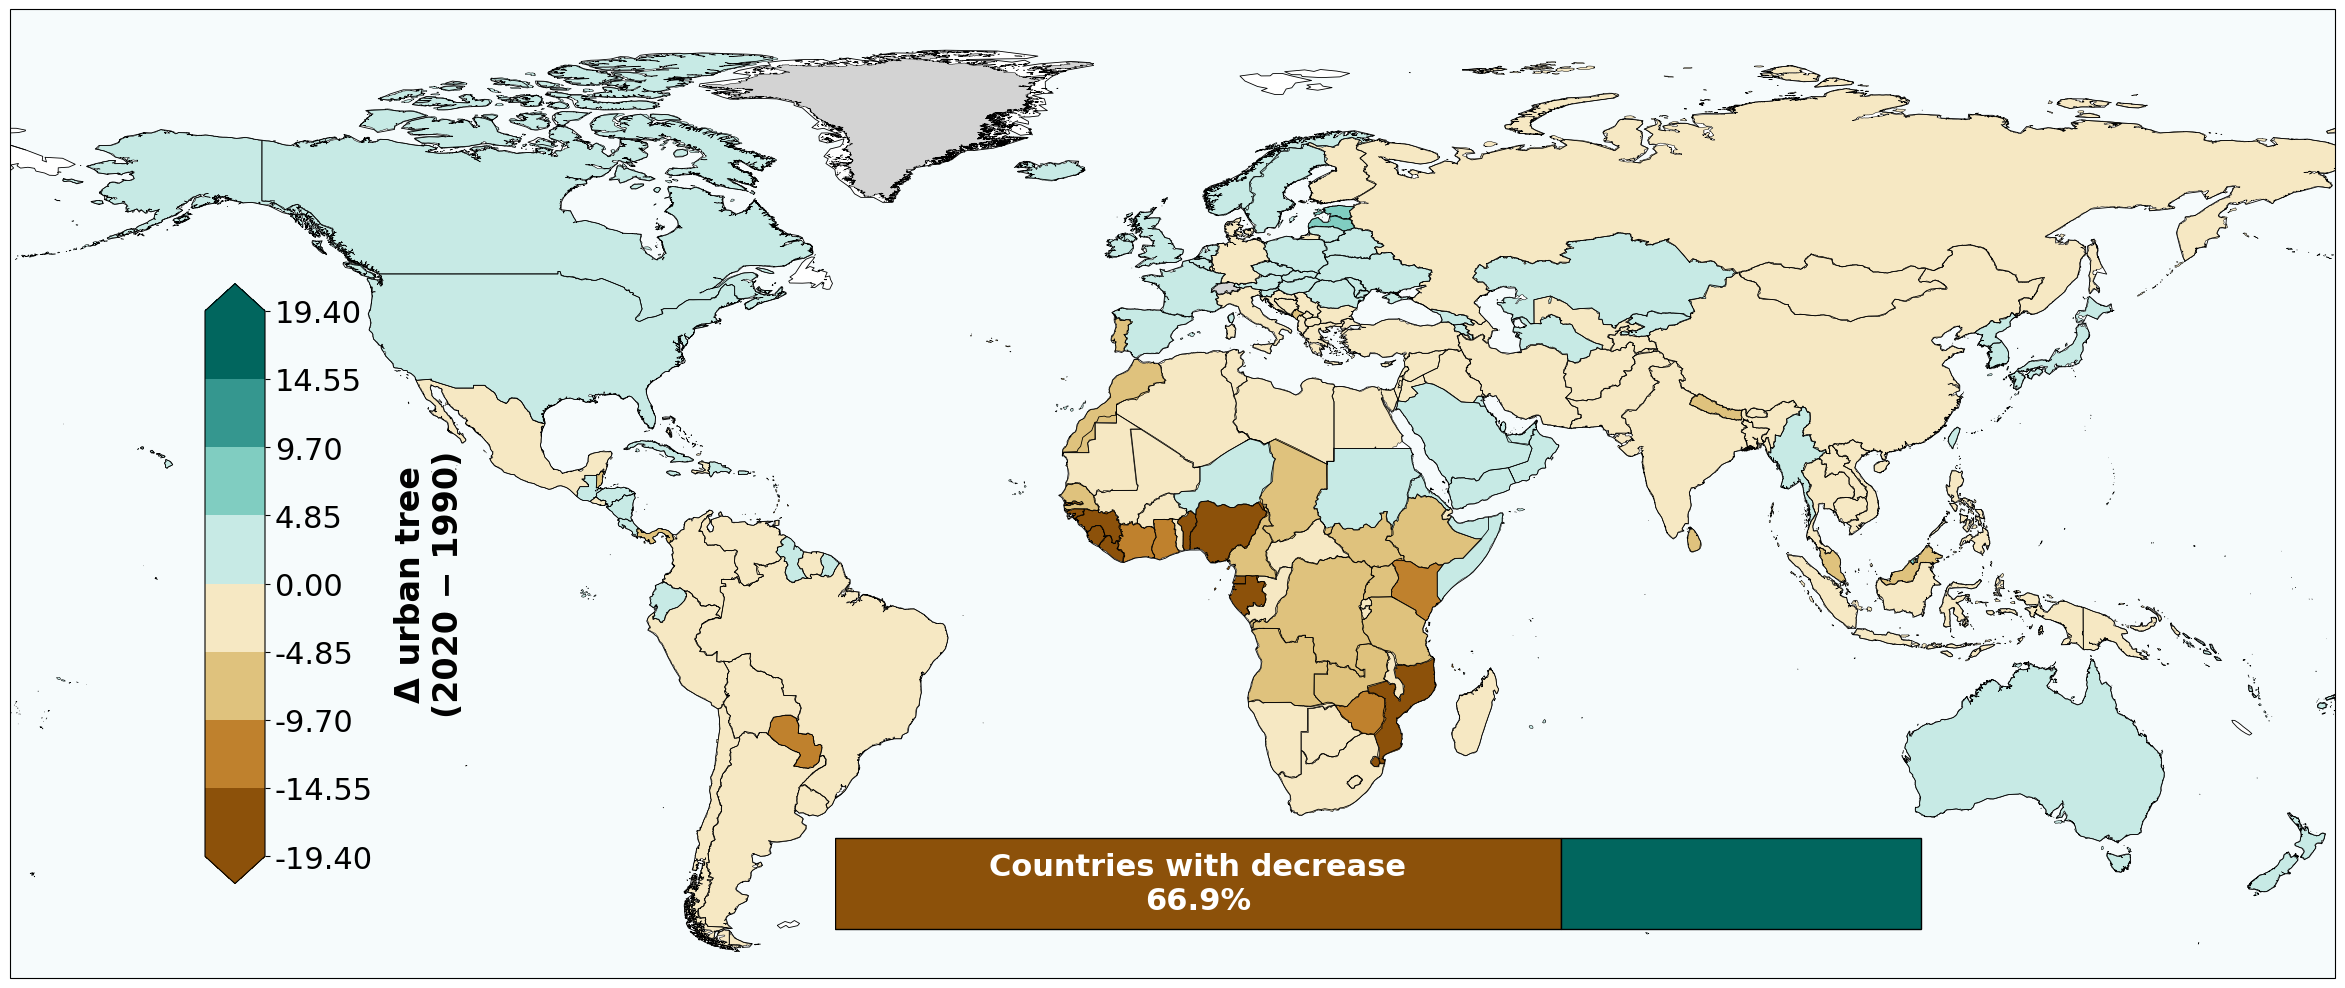

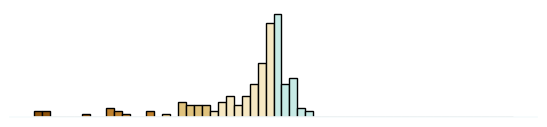

In [12]:
import os
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import shape as shp_shape
from matplotlib.colors import BoundaryNorm, ListedColormap
from matplotlib.cm import ScalarMappable

# -----------------------------
# CONFIG — edit these if needed
# -----------------------------
CSV_1990 = "/content/treeUrban_1990_constBuiltUp1992_100m.csv"
CSV_2020 = "/content/treeUrban_2020_constBuiltUp2020_100m.csv"

METRIC_COL = 'tree_pct_in_urban'  # or 'tree_frac_in_urban', 'tree_in_urban_m2'

MAP_FIG_PATH  = "/content/EDFig10A_map.pdf"
HIST_FIG_PATH = "/content/EDFig10A_hist.pdf"

# Diverging palette (brown → white → green; white is the zero *boundary* only)
DIVERGING_COLS = [
    '#8c510a', '#bf812d', '#dfc27d', '#f6e8c3',
    '#ffffff',
    '#c7eae5', '#80cdc1', '#35978f', '#01665e'
]
BROWN_LEFT = '#8c510a'  # negative side color (decrease)
TEAL_RIGHT = '#01665e'  # positive side color (increase)

# Compact % bar placement and style
PCT_BAR_BOX = [0.40, 0.275, 0.38, 0.05]  # [left, bottom, width, height] in figure coords
PCT_BAR_FONTSIZE = 22
INCLUDE_ZERO_IN_PCT = False  # False = exclude exact zeros from denominator

# -----------------------------
# Palette helpers (zero split)
# -----------------------------
def _split_center_palette(cols):
    if len(cols) % 2 != 1:
        raise ValueError("DIVERGING_COLS must have odd length with a single center color for 0.")
    mid = len(cols) // 2
    neg_cols = cols[:mid]      # below 0
    pos_cols = cols[mid+1:]    # above 0
    if len(neg_cols) != len(pos_cols):
        raise ValueError("Negative and positive sides must be symmetric in length.")
    return neg_cols, pos_cols

def _build_zero_split_bounds(abs_max, n_neg, n_pos):
    A = float(abs(abs_max))
    if not np.isfinite(A) or A <= 0:
        A = 1e-6
    left  = np.linspace(-A, 0.0, n_neg + 1, endpoint=True)
    right = np.linspace(0.0,  A, n_pos + 1, endpoint=True)[1:]  # drop duplicate 0
    return np.concatenate([left, right])

# -----------------------------
# I/O + validation helpers
# -----------------------------
def _load_pair():
    """Prefer in-memory; else read from CSV_1990/CSV_2020."""
    try:
        global treeUrban1990, treeUrban2020
        if isinstance(treeUrban1990, pd.DataFrame) and isinstance(treeUrban2020, pd.DataFrame):
            return treeUrban1990.copy(), treeUrban2020.copy()
    except NameError:
        pass

    if CSV_1990 is None or CSV_2020 is None:
        raise RuntimeError(
            "Provide in-memory DataFrames `treeUrban1990` & `treeUrban2020`, "
            "or set CSV_1990 and CSV_2020 to file paths."
        )
    if not os.path.exists(CSV_1990):
        raise FileNotFoundError(f"CSV_1990 not found: {CSV_1990}")
    if not os.path.exists(CSV_2020):
        raise FileNotFoundError(f"CSV_2020 not found: {CSV_2020}")

    try:
        df1990 = pd.read_csv(CSV_1990)
        df2020 = pd.read_csv(CSV_2020)
    except Exception as e:
        raise RuntimeError(f"Error reading CSVs: {e}") from e

    return df1990, df2020

def _ensure_cols(df, year_label):
    req = ['shapeName', METRIC_COL]
    miss = [c for c in req if c not in df.columns]
    if miss:
        raise KeyError(f"Missing required columns in {year_label}: {miss}")

def _add_geometry(df, year_label):
    """Create geometry from '.geo' if needed; return GeoDataFrame (EPSG:4326)."""
    if 'geometry' in df.columns and gpd.array.is_geometry_type(df['geometry']):
        return gpd.GeoDataFrame(df, geometry='geometry', crs='EPSG:4326')

    if '.geo' not in df.columns:
        raise KeyError(f"Neither 'geometry' nor '.geo' found in {year_label}; cannot build geometries.")

    def parse(x):
        if pd.isna(x):
            return None
        try:
            return shp_shape(json.loads(x))
        except Exception as e:
            raise RuntimeError(f"Failed parsing .geo in {year_label}: {e}") from e

    geom = df['.geo'].apply(parse)
    return gpd.GeoDataFrame(df.copy(), geometry=geom, crs='EPSG:4326')

# -----------------------------
# Compact % bar
# -----------------------------
def _draw_percent_bar(fig,
                      neg_pct, pos_pct,
                      neg_label="Decrease", pos_label="Increase",
                      box=PCT_BAR_BOX, fontsize=PCT_BAR_FONTSIZE,
                      left_color=BROWN_LEFT, right_color=TEAL_RIGHT,
                      swap_order=False):
    """
    Draw a small stacked horizontal bar on the figure (percent scale).
    - neg_pct/pos_pct: percentages (0–100).
    - swap_order=True places positive on the left.
    Only the 'decrease' (negative) segment is annotated.
    """
    try:
        neg = max(0.0, float(neg_pct))
        pos = max(0.0, float(pos_pct))
    except Exception as e:
        print(f"Warning: invalid percentages for percent bar: {e}")
        return

    total = neg + pos
    if total <= 0:
        return

    try:
        axb = fig.add_axes(list(box))
        axb.set_axis_off()

        if swap_order:
            # Positive on the LEFT, negative on the RIGHT
            axb.barh([""], [pos], color=right_color, edgecolor='black', height=0.6)
            axb.barh([""], [neg], color=left_color,  edgecolor='black', height=0.6, left=pos)

            # Only label the DECREASE (negative) segment
            if neg > 2:
                axb.text(pos + neg / 2.0, 0,
                         f"Countries with decrease\n{neg:.1f}%",
                         ha='center', va='center',
                         fontsize=fontsize, color='white', weight='bold')
        else:
            # Negative on the LEFT, positive on the RIGHT
            axb.barh([""], [neg], color=left_color,  edgecolor='black', height=0.6)
            axb.barh([""], [pos], color=right_color, edgecolor='black', height=0.6, left=neg)

            # Only label the DECREASE (negative) segment
            if neg > 2:
                axb.text(neg / 2.0, 0,
                         f"Countries with decrease\n{neg:.1f}%",
                         ha='center', va='center',
                         fontsize=fontsize, color='white', weight='bold')

        for s in axb.spines.values():
            s.set_visible(False)
        axb.set_xticks([])
        axb.set_yticks([])

    except Exception as e:
        print(f"Warning: percent bar failed to draw: {e}")

# -----------------------------
# Histogram (zero-break)
# -----------------------------
def create_frequency_plot_diverging(data, neg_cols, pos_cols, n_bins_half=120, save_path=None):
    """
    Frequency histogram with a hard class break at 0.
    Colors: negative bins use neg_cols; positive bins use pos_cols; 0 is a boundary.
    """
    try:
        arr = np.asarray(pd.to_numeric(data, errors='coerce'), dtype=float)
        arr = arr[~np.isnan(arr)]
        if arr.size == 0:
            raise ValueError("No valid data available for histogram plotting.")

        # Central 95% for stability
        p2_5, p97_5 = np.percentile(arr, [2.5, 97.5])
        arr = arr[(arr >= p2_5) & (arr <= p97_5)]
        if arr.size == 0:
            raise ValueError("No data within 2.5–97.5 percentile range.")

        # Symmetric span
        abs_max = max(abs(arr.min()), abs(arr.max()))
        if abs_max == 0:
            abs_max = 1e-6

        # Dense histogram bins (for smoothness)
        bins_left  = np.linspace(-abs_max, 0.0, int(n_bins_half) + 1)
        bins_right = np.linspace(0.0,  abs_max, int(n_bins_half) + 1)[1:]
        bins = np.concatenate([bins_left, bins_right])

        # Coarse class bounds with exact zero split
        bounds = _build_zero_split_bounds(abs_max, len(neg_cols), len(pos_cols))
        colors = neg_cols + pos_cols
        cmap = ListedColormap(colors)
        norm = BoundaryNorm(bounds, ncolors=len(colors), clip=True)

        # Plot
        fig, ax = plt.subplots(figsize=(6.8, 1.4))
        counts, edges, patches = ax.hist(arr, bins=bins, edgecolor='black', linewidth=1)

        # Color by class (midpoints)
        for patch, l, r in zip(patches, edges[:-1], edges[1:]):
            mid = 0.5 * (l + r)
            patch.set_facecolor(cmap(norm(mid)))

        # Zero reference
        # ax.axvline(0, color='black', linestyle='--', linewidth=1.2)

        # Minimal styling
        ax.set_xticks([]); ax.set_yticks([])
        for s in ax.spines.values(): s.set_visible(False)
        ax.spines['bottom'].set_visible(True)
        ax.spines['bottom'].set_color('#f6fbfc'); ax.spines['bottom'].set_linewidth(1.2)
        fig.patch.set_alpha(0); ax.patch.set_alpha(0)

        if save_path:
            os.makedirs(os.path.dirname(save_path), exist_ok=True)
            plt.savefig(save_path, dpi=400, bbox_inches='tight')
        plt.show()

    except Exception as e:
        raise RuntimeError(f"Error in creating diverging frequency plot: {e}")

# -----------------------------
# MAIN
# -----------------------------
def main():
    # 1) Load data
    df1990, df2020 = _load_pair()

    # 2) Validate columns
    _ensure_cols(df1990, "1990")
    _ensure_cols(df2020, "2020")

    # 3) Geometry
    gdf1990 = _add_geometry(df1990, "1990")
    gdf2020 = _add_geometry(df2020, "2020")

    # 4) Aggregate mean metric per shapeName
    try:
        g1990 = gdf1990.groupby("shapeName", as_index=False)[METRIC_COL].mean()
        g2020 = gdf2020.groupby("shapeName", as_index=False)[METRIC_COL].mean()
    except Exception as e:
        raise RuntimeError(f"Grouping/aggregation failed: {e}") from e

    # 5) Compute delta and attach geometry (use 2020 geometries as representative)
    merged = pd.merge(g1990, g2020, on="shapeName", suffixes=("_1990", "_2020"))
    merged["delta"] = merged[f"{METRIC_COL}_2020"] - merged[f"{METRIC_COL}_1990"]
    geo = gdf2020.drop_duplicates("shapeName")[["shapeName", "geometry"]]
    final = geo.merge(merged[["shapeName", "delta"]], on="shapeName", how="left")
    final = gpd.GeoDataFrame(final, geometry="geometry", crs="EPSG:4326")

    # 6) Build zero-split color logic
    try:
        neg_cols, pos_cols = _split_center_palette(DIVERGING_COLS)
    except Exception as e:
        raise RuntimeError(f"Palette error: {e}") from e

    # 7) MAP — exact zero break classes + % bar
    try:
        fig, ax = plt.subplots(figsize=(30, 20), subplot_kw={'projection': ccrs.PlateCarree()})
        ax.add_feature(cfeature.COASTLINE, linewidth=0.6)
        ax.add_feature(cfeature.BORDERS, linewidth=0.6)
        ax.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.1)
        ax.add_feature(cfeature.LAND, facecolor='white')
        ax.set_extent([-180, 180, -60, 90], crs=ccrs.PlateCarree())

        valid = final["delta"].dropna()
        if valid.empty:
            raise ValueError("No valid 'delta' values found for plotting.")

        # Robust symmetric span (95th percentile of |delta|)
        abs_max = np.percentile(np.abs(valid.to_numpy()), 95)
        if abs_max <= 0 or not np.isfinite(abs_max):
            abs_max = max(abs(valid.min()), abs(valid.max()), 1e-6)

        # Zero-split bounds and discrete cmap (no center color)
        bounds = _build_zero_split_bounds(abs_max, len(neg_cols), len(pos_cols))
        colors = neg_cols + pos_cols
        cmap_discrete = ListedColormap(colors)
        norm = BoundaryNorm(boundaries=bounds, ncolors=len(colors), clip=True)

        # Draw polygons
        final.plot(
            column="delta",
            ax=ax,
            cmap=cmap_discrete,
            norm=norm,
            edgecolor="black",
            linewidth=0.35,
            missing_kwds={'color': 'lightgrey', 'label': 'No data'}
        )

        # Colorbar with explicit 0 break
        cbar_ax = fig.add_axes([0.19, 0.3, 0.02, 0.3])
        sm = ScalarMappable(norm=norm, cmap=cmap_discrete); sm._A = []
        cbar = plt.colorbar(sm, cax=cbar_ax, orientation='vertical', extend='both')
        cbar.set_label("Δ urban tree\n(2020 − 1990)", fontsize=24, labelpad=15, fontweight='bold')
        cbar.set_ticks(bounds)
        cbar.set_ticklabels([f"{b:.2f}" for b in bounds])
        cbar.ax.tick_params(labelsize=22)

        # ===== Compact % bar (zeros excluded by default) =====
        if INCLUDE_ZERO_IN_PCT:
            base = float(valid.size)
            neg_pct = float((valid < 0).sum()) / base * 100.0
            pos_pct = float((valid > 0).sum()) / base * 100.0
        else:
            nz = valid[valid != 0]
            base = float(nz.size)
            neg_pct = float((nz < 0).sum()) / base * 100.0 if base > 0 else 0.0
            pos_pct = float((nz > 0).sum()) / base * 100.0 if base > 0 else 0.0

        _draw_percent_bar(
            fig,
            neg_pct=neg_pct, pos_pct=pos_pct,
            neg_label="Decrease", pos_label="Increase",
            box=PCT_BAR_BOX, fontsize=PCT_BAR_FONTSIZE,
            left_color=BROWN_LEFT, right_color=TEAL_RIGHT,
            swap_order=False  # set True to place 'Increase' on the left
        )
        # If this were URBAN − RURAL contrasts instead of temporal change:
        # _draw_percent_bar(fig, neg_pct, pos_pct, "Rural > Urban", "Urban > Rural", box=PCT_BAR_BOX)

        os.makedirs(os.path.dirname(MAP_FIG_PATH), exist_ok=True)
        plt.savefig(MAP_FIG_PATH, bbox_inches='tight', dpi=400)
        plt.show()

    except Exception as e:
        raise RuntimeError(f"Error during diverging map plot: {e}") from e

    # 8) HISTOGRAM — same zero-break logic
    try:
        create_frequency_plot_diverging(
            data=valid,
            neg_cols=neg_cols,
            pos_cols=pos_cols,
            n_bins_half=30,
            save_path=HIST_FIG_PATH
        )
    except Exception as e:
        raise RuntimeError(f"Error during diverging histogram plot: {e}") from e

if __name__ == "__main__":
    try:
        main()
    except Exception as e:
        import sys, traceback
        print(f"\nERROR: {e}", file=sys.stderr)
        traceback.print_exc(limit=2)
